## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import re
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
BASE_DIR = "/content/drive/MyDrive/Aiops-Dataset"
DATE = "2022-05-03"
LOGS_EMB_MAPPING_QWEN_PARQUET = f"/content/drive/MyDrive/qwen3_embeddings.parquet"
LOGS_EMB_MAPPING_E5_SMALL_PARQUET = f"/content/drive/MyDrive/model_e5_small_embeddings_recalculated.parquet"
LOGS_CSV = f"{BASE_DIR}/data/{DATE}/log/all/log_filebeat-testbed-log-service.csv"
INCIDENTS_CSV = f"{BASE_DIR}/groundtruth/groundtruth-{DATE}.csv"
FREQ = "1min"
PRE_WINDOW_MIN = 15
ROLL_W = 5
TRAIN_RATIO = 0.7
EMB_COL_NAME = "embedding"


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [4]:
def read_csv_dataset(file_path, sep=','):
    return pd.read_csv(file_path, sep=sep)

def convert_timestamps_to_datetime(df, timestamp_column_name='timestamp', timestamp_unit='s'):
    df['datetime'] = pd.to_datetime(df[timestamp_column_name], unit=timestamp_unit)
    return df

def get_data(file_path, sep=',', timestamp_column_name='timestamp', timestamp_unit='s'):
    df = read_csv_dataset(file_path, sep=sep)
    df = convert_timestamps_to_datetime(df, timestamp_column_name, timestamp_unit)
    print(f"Dataset shape: {df.shape}")
    return df

def normalize_log(line: str) -> str:
    return re.sub(r'\d+', '<NUM>', str(line))

# def build_labels_with_cooldown(dt, incidents_df, pre_minutes=15, cooldown_minutes=15):
#     """

#     incidents_df: DataFrame с колонкой 'datetime' для инцидентов

#     Возвращает:
#       y: 0/1 Series (1 = pre-failure), индекс тот же, что у dt_series
#       mask_keep: bool Series (False = выкинуть из train/test)
#     """
#     # приводим к numpy-массиву для позиционных масок
#     times = pd.to_datetime(dt.to_numpy())
#     if isinstance(dt, pd.Series):
#         idx = dt.index
#     else:
#         idx = dt  # DatetimeIndex / Index
#     idx = dt_series.index                         # индекс логов (RangeIndex / что угодно)

#     y = pd.Series(0, index=idx, dtype=int)
#     mask_keep = pd.Series(True, index=idx, dtype=bool)

#     for t in pd.to_datetime(incidents_df['datetime']):
#         pre_start = t - pd.Timedelta(minutes=pre_minutes)
#         post_end  = t + pd.Timedelta(minutes=cooldown_minutes)

#         pre_mask   = (times >= pre_start) & (times <= t)      # numpy bool array
#         cooldown_mask = (times >= t) & (times < post_end)

#         # позиционная индексация — не завязана на именах индекса
#         y.iloc[pre_mask] = 1
#         mask_keep.iloc[cooldown_mask] = False

#     return y, mask_keep

import pandas as pd


def build_labels_with_cooldown(dt, incidents_df, pre_minutes: int = 15, cooldown_minutes: int = 15):
    """
    dt: Series или Index с временными метками (например X_all.index или logs_df["datetime"])
    incidents_df: DataFrame с колонкой 'datetime' для инцидентов

    Возвращает:
      y: 0/1 Series (1 = pre-failure), индекс тот же, что у dt
      mask_keep: bool Series (False = выкинуть из train/test — cooldown зона)
    """
    # Приводим ко временным меткам и единому индексу
    dt_index = pd.Index(dt)                       # безопасно для Series, Index, list, np.array
    times = pd.to_datetime(dt_index.to_numpy())   # numpy-массив дат/времени
    idx = dt_index                                # индекс для y и mask_keep

    y = pd.Series(0, index=idx, dtype=int)
    mask_keep = pd.Series(True, index=idx, dtype=bool)

    # Перебираем инциденты
    for t in pd.to_datetime(incidents_df['datetime']):
        pre_start = t - pd.Timedelta(minutes=pre_minutes)
        post_end  = t + pd.Timedelta(minutes=cooldown_minutes)

        pre_mask      = (times >= pre_start) & (times <= t)
        cooldown_mask = (times >= t) & (times < post_end)

        # позиционная индексация — не завязана на именах индекса
        y.iloc[pre_mask] = 1
        mask_keep.iloc[cooldown_mask] = False

    return y, mask_keep


  # new version
def extract_prefailure_intervals(model_preds: pd.Series, min_len: str | None = None, merge_gap: str | None = None):
    model_preds_prepared = pd.Series(model_preds).fillna(False).astype(bool).sort_index()
    # if s.empty or not s.any():
    #     return []
    runs, in_run, start, prev = [], False, None, None
    for ts, v in model_preds_prepared.items():
        if v and not in_run:
            in_run, start = True, ts
        elif not v and in_run:
            runs.append({"start": start, "end": prev})  # end = последняя True-метка
            in_run, start = False, None
        prev = ts

    # tail case
    if in_run:
        runs.append({"start": start, "end": prev})

    # filter small duration
    # if min_len:
    #     ml = pd.Timedelta(min_len)
    #     runs = [r for r in runs if (r["end"] - r["start"]) >= ml]

    # if merge_gap and runs:
    #     gap = pd.Timedelta(merge_gap)
    #     merged = [runs[0]]
    #     for r in runs[1:]:
    #         if r["start"] - merged[-1]["end"] <= gap:
    #             merged[-1]["end"] = max(merged[-1]["end"], r["end"])
    #         else:
    #             merged.append(r)
    #     runs = merged
    return runs


def make_alert_series(y_score_or_bin: pd.Series, thr=0.5, smooth="3min",
                      min_len="2min", merge_gap="3min", cooldown="10min"):
    """
    Строит устойчивую алёрт-серию и список эпизодов.
    Требуется монотонный DatetimeIndex для time-based rolling ('3min').  # pandas window docs
    """
    model_predictions = pd.Series(y_score_or_bin).copy()

    # convert predictions into 0s and 1s
    if model_predictions.dtype not in (int, bool, np.int64, np.int32):
        model_predictions = (model_predictions >= float(thr)).astype(int)
    model_predictions = model_predictions.fillna(0).astype(int).sort_index()

    # time-based rolling требует монотонный индекс (pandas docs)
    # if smooth:
    #     s = s.rolling(smooth, min_periods=1).max().astype(int)

    # extract failure episodes from prediction
    runs = extract_prefailure_intervals(model_predictions, min_len=min_len, merge_gap=merge_gap)

    # if cooldown and runs:
    #     cd = pd.Timedelta(cooldown)
    #     cooled = [runs[0]]
    #     for r in runs[1:]:
    #         if r["start"] <= cooled[-1]["end"] + cd:
    #             cooled[-1]["end"] = max(cooled[-1]["end"], r["end"])
    #         else:
    #             cooled.append(r)
    #     runs = cooled

    out = pd.Series(0, index=model_predictions.index, dtype=int)
    for r in runs:
        out[(out.index >= r["start"]) & (out.index <= r["end"])] = 1
    return out, runs


# def eval_incident_metrics_robust(
#     y_score_or_bin: pd.Series,
#     incidents: pd.DataFrame,
#     pre_minutes: int,
#     thr: float = 0.5,
#     smooth: str = "3min",
#     min_len: str = "2min",
#     merge_gap: str = "3min",
#     cooldown: str = "10min",
#     y_true: pd.Series | None = None
# ):
#     alert_bin, alert_runs = make_alert_series(
#         y_score_or_bin, thr=thr, smooth=smooth, min_len=min_len,
#         merge_gap=merge_gap, cooldown=cooldown
#     )

#     alert_bin = alert_bin.sort_index()
#     idx = alert_bin.index

#     inc_times = pd.to_datetime(incidents["datetime"])
#     inc_times = inc_times.sort_values()

#     start, end = idx.min(), idx.max()
#     pre = pd.Timedelta(minutes=pre_minutes)

#     w_starts = inc_times - pre
#     # filter to have time range in initial labels and predictions the similar
#     mask = (w_starts < end) & (inc_times > start)
#     inc_times = inc_times.loc[mask]
#     windows = [(t - pre, t) for t in inc_times]

#     TP, FN = 0, 0
#     mttd_vals, rows = [], []

#     def overlaps(run, ws, we):
#         return not (run["end"] < ws or run["start"] >= we)

#     for w_start, w_end in windows:
#         # совпавшие pre-failure predictions
#         hits = [r for r in alert_runs if overlaps(r, w_start, w_end)]
#         if hits:
#             first_alert_time = min(max(r["start"], w_start) for r in hits)
#             mttd = (w_end - first_alert_time).total_seconds() / 60.0
#             TP += 1; mttd_vals.append(mttd)
#             rows.append({"incident_time": w_end, "detected": True,
#                          "first_alert_time": first_alert_time, "MTTD_min": mttd})
#         else:
#             FN += 1
#             rows.append({"incident_time": w_end, "detected": False,
#                          "first_alert_time": pd.NaT, "MTTD_min": np.nan})

#     # go through pre-failure predictions,
#     # not overlapped with real pre-failure intervals - false positives
#     def overlaps_any(run, wins):
#         return any(overlaps(run, ws, we) for (ws, we) in wins)
#     fp_runs = [r for r in alert_runs if not overlaps_any(r, windows)]
#     FP = len(fp_runs)

#     prec_inc = TP/(TP+FP) if TP+FP>0 else 0.0
#     rec_inc  = TP/(TP+FN) if TP+FN>0 else 0.0
#     f1_inc   = 2*prec_inc*rec_inc/(prec_inc+rec_inc) if prec_inc+rec_inc>0 else 0.0
#     mean_mttd = float(np.nanmean(mttd_vals)) if mttd_vals else np.nan
#     p90_mttd = float(np.nanpercentile(mttd_vals, 90)) if mttd_vals else np.nan

#     hours_total = (end - start).total_seconds()/3600.0 if (pd.notna(end) and pd.notna(start)) else np.nan
#     fp_per_hour = FP / hours_total if hours_total and hours_total>0 else np.nan
#     percentage_of_ones_in_prediction = float(alert_bin.mean()*100.0)

#     out = {
#         "incident_precision": prec_inc,
#         "incident_recall": rec_inc,
#         "incident_f1": f1_inc,
#         "TP_incidents": TP,
#         "FN_incidents": FN,
#         "FP_episodes": FP,
#         "FP_per_hour": fp_per_hour,
#         "mean_MTTD_min": mean_mttd,
#         "p90_MTTD_min": p90_mttd,
#         "percentage_of_ones_in_prediction": percentage_of_ones_in_prediction,
#         "incident_table": pd.DataFrame(rows),
#         "fp_episode_table": pd.DataFrame(fp_runs),
#     }

#     if y_true is not None:
#         y_bin_input = pd.Series(y_score_or_bin)
#         if y_bin_input.dtype != int:
#             y_bin = (y_bin_input >= thr).astype(int)
#         else:
#             y_bin = y_bin_input.astype(int)
#         y_bin = y_bin.reindex(alert_bin.index).fillna(0).astype(int)

#         out.update({
#             "classic_precision": precision_score(y_true, y_bin, zero_division=0),
#             "classic_recall": recall_score(y_true, y_bin, zero_division=0),
#             "classic_f1": f1_score(y_true, y_bin, zero_division=0),
#         })
#     return out

def eval_incident_metrics_robust(
    y_score_or_bin: pd.Series,
    incidents: pd.DataFrame,
    pre_minutes: int,
    thr: float = 0.5,
    smooth: str = "3min",
    min_len: str = "2min",
    merge_gap: str = "3min",
    cooldown: str = "10min",
    y_true: pd.Series | None = None,
):
    """
    y_score_or_bin : Series с предсказаниями модели (скор или уже бинарный 0/1), индекс = DatetimeIndex
    incidents      : DataFrame с колонкой 'datetime' (время инцидентов)
    pre_minutes    : длина pre-failure окна в минутах (t - pre_minutes, t)
    thr            : порог для бинаризации, если на вход подаются скоры
    smooth, min_len, merge_gap, cooldown : параметры устойчивого алёрт-сигнала (используются в make_alert_series)
    y_true         : опционально, true labels (0/1) по тем же временным меткам для classic precision/recall/f1

    Возвращает dict с ключами:
      - incident_precision / incident_recall / incident_f1
      - TP_incidents / FN_incidents / FP_episodes / FP_per_hour
      - mean_MTTD_min / p90_MTTD_min
      - percentage_of_ones_in_prediction
      - fp_time_min
      - fp_time_percent              : % FP-времени от всего горизонта
      - fp_time_alert_percent        : % FP-времени от времени, когда был алёрт
      - fp_time_nonwindow_percent    : % FP-времени от времени, где алёртов быть не должно (вне pre-window)
      - classic_precision / classic_recall / classic_f1 (если y_true задан)
      - incident_table / fp_episode_table (DataFrame-ы)
    """

    # 1. Строим устойчивый алёрт-сигнал и эпизоды (runs)
    alert_bin, alert_runs = make_alert_series(
        y_score_or_bin,
        thr=thr,
        smooth=smooth,
        min_len=min_len,
        merge_gap=merge_gap,
        cooldown=cooldown,
    )

    alert_bin = alert_bin.sort_index()
    idx = alert_bin.index

    inc_times = pd.to_datetime(incidents["datetime"]).sort_values()

    start, end = idx.min(), idx.max()
    pre = pd.Timedelta(minutes=pre_minutes)

    # pre-failure окна для инцидентов
    windows = [(t - pre, t) for t in inc_times]

    # ==========================
    # 1) FP_TIME в МИНУТАХ
    # ==========================
    # маска: находим точки, которые лежат внутри хотя бы одного pre-window
    in_window = pd.Series(False, index=idx, dtype=bool)
    for ws, we in windows:
        in_window |= (idx >= ws) & (idx <= we)

    # дельты между соседними временными метками (в секундах → переведём в минуты)
    ts_series = pd.Series(idx, index=idx)
    deltas_sec = (ts_series.shift(-1) - ts_series).dt.total_seconds()
    deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
    deltas_min = deltas_sec / 60.0

    mask_alert = alert_bin.astype(bool)
    mask_fp_points = mask_alert & (~in_window)

    fp_minutes = float((deltas_min * mask_fp_points).sum())
    total_minutes = float(deltas_min.sum())
    alert_minutes = float((deltas_min * mask_alert).sum())

    # суммарное время вне pre-window'ов (где алёртов "не должно быть")
    non_window_mask = ~in_window
    non_window_minutes = float((deltas_min * non_window_mask).sum())

    fp_time_min = fp_minutes
    fp_time_percent = (
        fp_minutes / total_minutes * 100.0 if total_minutes > 0 else np.nan
    )
    fp_time_alert_percent = (
        fp_minutes / alert_minutes * 100.0 if alert_minutes > 0 else np.nan
    )
    fp_time_nonwindow_percent = (
        fp_minutes / non_window_minutes * 100.0
        if non_window_minutes > 0
        else np.nan
    )
    # ==========================

    # 2. Incident-level TP/FN + MTTD по прежней логике
    TP, FN = 0, 0
    mttd_vals, rows = [], []

    def overlaps(run, ws, we):
        return not (run["end"] < ws or run["start"] >= we)

    for w_start, w_end in windows:
        hits = [r for r in alert_runs if overlaps(r, w_start, w_end)]
        if hits:
            first_alert_time = min(max(r["start"], w_start) for r in hits)
            mttd = (w_end - first_alert_time).total_seconds() / 60.0
            TP += 1
            mttd_vals.append(mttd)
            rows.append(
                {
                    "incident_time": w_end,
                    "detected": True,
                    "first_alert_time": first_alert_time,
                    "MTTD_min": mttd,
                }
            )
        else:
            FN += 1
            rows.append(
                {
                    "incident_time": w_end,
                    "detected": False,
                    "first_alert_time": pd.NaT,
                    "MTTD_min": np.nan,
                }
            )

    # 3. FP-эпизоды по старой логике (эпизоды, не пересекающие ни одно pre-window)
    def overlaps_any(run, wins):
        return any(overlaps(run, ws, we) for (ws, we) in wins)

    fp_runs = [r for r in alert_runs if not overlaps_any(r, windows)]
    FP = len(fp_runs)

    # 4. Инцидентные метрики
    prec_inc = TP / (TP + FP) if TP + FP > 0 else 0.0
    rec_inc = TP / (TP + FN) if TP + FN > 0 else 0.0
    f1_inc = (
        2 * prec_inc * rec_inc / (prec_inc + rec_inc)
        if prec_inc + rec_inc > 0
        else 0.0
    )
    mean_mttd = float(np.nanmean(mttd_vals)) if mttd_vals else np.nan
    p90_mttd = float(np.nanpercentile(mttd_vals, 90)) if mttd_vals else np.nan

    hours_total = (
        (end - start).total_seconds() / 3600.0
        if (pd.notna(end) and pd.notna(start))
        else np.nan
    )
    fp_per_hour = FP / hours_total if hours_total and hours_total > 0 else np.nan
    percentage_of_ones_in_prediction = float(alert_bin.mean() * 100.0)

    out = {
        "incident_precision": prec_inc,
        "incident_recall": rec_inc,
        "incident_f1": f1_inc,
        "TP_incidents": TP,
        "FN_incidents": FN,
        "FP_episodes": FP,
        "FP_per_hour": fp_per_hour,
        "mean_MTTD_min": mean_mttd,
        "p90_MTTD_min": p90_mttd,
        "percentage_of_ones_in_prediction": percentage_of_ones_in_prediction,
        "incident_table": pd.DataFrame(rows),
        "fp_episode_table": pd.DataFrame(fp_runs),
        # новые поля:
        "fp_time_min": fp_time_min,                         # минуты в FP-состоянии вне окон
        "fp_time_percent": fp_time_percent,                 # % от общего времени
        "fp_time_alert_percent": fp_time_alert_percent,     # % от времени алёрта, оказавшегося ложным
        "fp_time_nonwindow_percent": fp_time_nonwindow_percent,  # % от времени вне окон, оказавшегося FP
    }

    # 5. Классические precision/recall/f1 по точкам (если есть y_true)
    if y_true is not None:
        y_bin_input = pd.Series(y_score_or_bin)
        if y_bin_input.dtype != int:
            y_bin = (y_bin_input >= thr).astype(int)
        else:
            y_bin = y_bin_input.astype(int)

        # привести к тому же индексу, что и alert_bin
        y_bin = y_bin.reindex(alert_bin.index).fillna(0).astype(int)

        out.update(
            {
                "classic_precision": precision_score(
                    y_true, y_bin, zero_division=0
                ),
                "classic_recall": recall_score(y_true, y_bin, zero_division=0),
                "classic_f1": f1_score(y_true, y_bin, zero_division=0),
            }
        )

    return out



def predict_and_evaluate_robust(models_dict, X_train, y_train, X_test, y_test,
                                incidents_df, pre_window_min,
                                fp_per_hour_limit: float = 0.1,
                                smooth="3min", min_len="2min", merge_gap="3min", cooldown="10min"):
    for model in models_dict.values():
        model.fit(X_train.values, y_train.values)

    rows, details = [], {}
    for name, m in models_dict.items():
        # predicted pre-failure
        yhat = pd.Series(m.predict(X_test.values), index=X_test.index).astype(int)
        eval_res = eval_incident_metrics_robust(
            yhat, incidents_df[["datetime"]], pre_window_min,
            thr=0.5, smooth=smooth, min_len=min_len, merge_gap=merge_gap, cooldown=cooldown,
            y_true=y_test
        )
        details[name] = eval_res
        rows.append({
            "model": name,
            "threshold": 0.5,
            "incident_precision": eval_res['incident_precision'],
            "incident_recall": eval_res['incident_recall'],
            "incident_f1": eval_res['incident_f1'],
            "mean_MTTD": eval_res['mean_MTTD_min'],
            "p90_MTTD": eval_res['p90_MTTD_min'],
            "TP_incidents": eval_res['TP_incidents'],
            "FN_incidents": eval_res['FN_incidents'],
            "FP_incidents": eval_res['FP_episodes'],
            "FP_per_hour": eval_res['FP_per_hour'],
            "percentage_of_ones_in_prediction": eval_res['percentage_of_ones_in_prediction'],
            "classic_precision": eval_res.get('classic_precision', np.nan),
            "classic_recall": eval_res.get('classic_recall', np.nan),
            "classic_f1": eval_res.get('classic_f1', np.nan),
            #"fp_time_min": eval_res.get('fp_time_min', np.nan),                     # минуты в FP-состоянии вне окон
            #"fp_time_percent": eval_res.get('fp_time_percent', np.nan),            # % от общего времени
            #"fp_time_alert_percent": eval_res.get('fp_time_alert_percent', np.nan),
            "fp_time_nonwindow_percent": eval_res.get('fp_time_nonwindow_percent', np.nan)
        })

    summary_df = pd.DataFrame(rows).sort_values('incident_f1', ascending=False).reset_index(drop=True)
    return summary_df, details


## Logs import

In [5]:
logs_df = get_data(LOGS_CSV)
logs_df['normalized_value'] = logs_df['value'].apply(normalize_log)
logs_df.head()

Dataset shape: (5444332, 6)


,log_id,timestamp,cmdb_id,log_name,value,datetime,normalized_value
0,Cp6Bt38B8vQa58bZsQau,1651507200,frontend-1,log_frontend-service_application,"severity: debug, message: request complete",2022-05-02 16:00:00,"severity: debug, message: request complete"
1,EZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 16:00:00,Executing endpoint 'gRPC - /hipstershop.C...
2,FZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...
3,Fp6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Request finished in 0.6231ms 200 applicat...,2022-05-02 16:00:00,Request finished in <NUM>.<NUM>ms <NUM> a...
4,F56Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...


In [6]:
logs_qwen_emb_mapping_df = pd.read_parquet(LOGS_EMB_MAPPING_QWEN_PARQUET)
logs_qwen_emb_mapping_df.head()

,text,embedding
0,"severity: debug, message: request complete","[0.009528516, 0.02508107, -0.010697219, -0.022..."
1,Executing endpoint 'gRPC - /hipstershop.C...,"[-0.0070184073, 0.08379098, -0.0048474898, -0...."
2,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[0.024719233, -0.03646279, -0.0123791965, -0.0..."
3,Request finished in <NUM>.<NUM>ms <NUM> a...,"[-0.024744842, -0.00058876147, -0.012140274, -..."
4,Request starting HTTP/<NUM> POST http://c...,"[-0.03154081, 0.0556518, -0.008348354, -0.0329..."


In [7]:
logs_small_e5_emb_mapping_df = pd.read_parquet(LOGS_EMB_MAPPING_E5_SMALL_PARQUET)
logs_small_e5_emb_mapping_df.head()

,text,embedding
0,"severity: debug, message: request complete","[-0.06920783, 0.07727577, 0.019308785, 0.00917..."
1,Executing endpoint 'gRPC - /hipstershop.C...,"[-0.0464766, 0.028303029, 0.011438629, 0.01614..."
2,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[-0.08472934, 0.02868341, 0.036607206, -0.0189..."
3,Request finished in <NUM>.<NUM>ms <NUM> a...,"[-0.063579105, 0.025242412, 0.0009641917, 0.01..."
4,Request starting HTTP/<NUM> POST http://c...,"[-0.06034003, 0.03742813, 0.009989894, -0.0020..."


In [8]:
logs_with_qwen_emb_mapped_df = logs_df.merge(
    logs_qwen_emb_mapping_df,
    how='left',
    left_on='normalized_value',
    right_on='text'
)
logs_with_qwen_emb_mapped_df.head()

,log_id,timestamp,cmdb_id,log_name,value,datetime,normalized_value,text,embedding
0,Cp6Bt38B8vQa58bZsQau,1651507200,frontend-1,log_frontend-service_application,"severity: debug, message: request complete",2022-05-02 16:00:00,"severity: debug, message: request complete","severity: debug, message: request complete","[0.009528516, 0.02508107, -0.010697219, -0.022..."
1,EZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 16:00:00,Executing endpoint 'gRPC - /hipstershop.C...,Executing endpoint 'gRPC - /hipstershop.C...,"[-0.0070184073, 0.08379098, -0.0048474898, -0...."
2,FZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[0.024719233, -0.03646279, -0.0123791965, -0.0..."
3,Fp6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Request finished in 0.6231ms 200 applicat...,2022-05-02 16:00:00,Request finished in <NUM>.<NUM>ms <NUM> a...,Request finished in <NUM>.<NUM>ms <NUM> a...,"[-0.024744842, -0.00058876147, -0.012140274, -..."
4,F56Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[0.024719233, -0.03646279, -0.0123791965, -0.0..."


In [9]:
logs_with_small_e5_emb_mapped_df = logs_df.merge(
    logs_small_e5_emb_mapping_df,
    how='left',
    left_on='normalized_value',
    right_on='text'
)
logs_with_small_e5_emb_mapped_df.head()

,log_id,timestamp,cmdb_id,log_name,value,datetime,normalized_value,text,embedding
0,Cp6Bt38B8vQa58bZsQau,1651507200,frontend-1,log_frontend-service_application,"severity: debug, message: request complete",2022-05-02 16:00:00,"severity: debug, message: request complete","severity: debug, message: request complete","[-0.06920783, 0.07727577, 0.019308785, 0.00917..."
1,EZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 16:00:00,Executing endpoint 'gRPC - /hipstershop.C...,Executing endpoint 'gRPC - /hipstershop.C...,"[-0.0464766, 0.028303029, 0.011438629, 0.01614..."
2,FZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[-0.08472934, 0.02868341, 0.036607206, -0.0189..."
3,Fp6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Request finished in 0.6231ms 200 applicat...,2022-05-02 16:00:00,Request finished in <NUM>.<NUM>ms <NUM> a...,Request finished in <NUM>.<NUM>ms <NUM> a...,"[-0.063579105, 0.025242412, 0.0009641917, 0.01..."
4,F56Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[-0.08472934, 0.02868341, 0.036607206, -0.0189..."


In [10]:
incidents_df = get_data(INCIDENTS_CSV)
service_incidents_df = incidents_df[incidents_df['level']=='service'].copy()
service_incidents_df.sort_values("datetime", inplace=True)
service_incidents_df.head()

Dataset shape: (50, 5)


,timestamp,level,cmdb_id,failure_type,datetime
43,1651514529,service,adservice,Kubernetes Container Network Latency,2022-05-02 18:02:09
5,1651519906,service,productcatalogservice,Kubernetes Container Network Resource Packet D...,2022-05-02 19:31:46
8,1651523554,service,recommendationservice,Kubernetes Container Read I/O Load,2022-05-02 20:32:34
44,1651526238,service,recommendationservice,Kubernetes Container Process Termination,2022-05-02 21:17:18
10,1651529574,service,frontend,Kubernetes Container Network Resource Packet D...,2022-05-02 22:12:54


In [11]:
# def make_train_test_split_with_cooldown(
#     logs_df,
#     incidents_df,
#     train_ratio=0.8,
#     pre_minutes=15,
#     cooldown_minutes=15,
#     datetime_col="datetime",
# ):
#     """
#     Возвращает:
#       logs_train_df: логи train (с label и split)
#       logs_test_df:  логи test (с label и split)
#       split_series:  Series с меткой 'train'/'test' по индексу logs_df после фильтрации
#       cut_ts:        таймстемп границы сплита
#     Печатает:
#       кол-во инцидентов в train и test
#     """
#     # 1. сортируем логи
#     logs = logs_df.sort_values(datetime_col).copy()

#     # 2. разметка + маска cooldown
#     y, mask_keep = build_labels_with_cooldown(
#         dt_series=logs[datetime_col],
#         incidents_df=incidents_df,
#         pre_minutes=pre_minutes,
#         cooldown_minutes=cooldown_minutes,
#     )

#     logs["label"] = y
#     logs["keep"] = mask_keep

#     # выкидываем серые зоны сразу после инцидента
#     logs = logs[logs["keep"]].drop(columns=["keep"])

#     # 3. считаем cut_ts по инцидентам
#     inc_times = incidents_df[datetime_col].sort_values().tolist()
#     if len(inc_times) == 0:
#         raise ValueError("incidents_df пустой — не из чего считать сплит")

#     split_idx = max(1, int(len(inc_times) * train_ratio))

#     if split_idx >= len(inc_times):
#         # все инциденты считаем train, test инцидентов нет
#         cut_ts = inc_times[-1]
#     else:
#         first_test_incident = inc_times[split_idx]
#         cut_ts = first_test_incident - pd.Timedelta(minutes=pre_minutes)

#     # 4. добавляем метку сплита в логи
#     logs["split"] = np.where(logs[datetime_col] < cut_ts, "train", "test")

#     # 5. делим логи
#     logs_train_df = logs[logs["split"] == "train"]
#     logs_test_df  = logs[logs["split"] == "test"]

#     # 6. считаем инциденты в train/test по cut_ts
#     inc_train_df = incidents_df[incidents_df[datetime_col] < cut_ts]
#     inc_test_df  = incidents_df[incidents_df[datetime_col] >= cut_ts]

#     print(f"Train logs: {logs_train_df.shape}")
#     print(f"Test  logs: {logs_test_df.shape}")
#     print(f"Incidents in TRAIN: {len(inc_train_df)}")
#     print(f"Incidents in TEST : {len(inc_test_df)}")

#     # 7. split_series можно использовать как "метку различения"
#     split_series = logs["split"].copy()

#     return logs_train_df, logs_test_df, cut_ts


def make_train_test_split_with_cooldown(
    logs_df,
    incidents_df,
    train_ratio=0.8,
    pre_minutes=15,
    cooldown_minutes=15,
    datetime_col="datetime",
    bin_freq="1min",          # частота, с которой ты потом бинишь фичи
    snap_to_bin=True,         # выровнять cut_ts по минутным бинам
):
    """
    Возвращает:
      logs_train_df: логи train (с label и split)
      logs_test_df:  логи test (с label и split)
      cut_ts_raw:    "сырая" граница (incident_time - pre_minutes)
      cut_ts:        финальная граница с учётом бинования (если snap_to_bin=True - подвинут к бин-границе)

    Печатает:
      кол-во логов и инцидентов в train и test
    """
    # 1. сортируем логи
    logs = logs_df.sort_values(datetime_col).copy()

    # 2. разметка + маска cooldown
    y, mask_keep = build_labels_with_cooldown(
        dt=logs[datetime_col],
        incidents_df=incidents_df,
        pre_minutes=pre_minutes,
        cooldown_minutes=cooldown_minutes,
    )

    logs["label"] = y.to_numpy()
    logs["keep"]  = mask_keep.to_numpy()


    # выкидываем серые зоны сразу после инцидента
    logs = logs[logs["keep"]].drop(columns=["keep"])

    # 3. считаем cut_ts по инцидентам (как раньше)
    inc_times = incidents_df[datetime_col].sort_values().tolist()
    if len(inc_times) == 0:
        raise ValueError("incidents_df пустой — не из чего считать сплит")

    split_idx = max(1, int(len(inc_times) * train_ratio))

    if split_idx >= len(inc_times):
        # все инциденты считаем train, test инцидентов нет
        cut_ts_raw = inc_times[-1]
    else:
        first_test_incident = inc_times[split_idx]
        cut_ts_raw = first_test_incident - pd.Timedelta(minutes=pre_minutes)

    # 4. при необходимости выравниваем границу по минутному бину
    if snap_to_bin:
        # вариант А: минута cut_ts_raw целиком в TRAIN, test с начала следующей минуты
        cut_ts = cut_ts_raw.floor(bin_freq) + pd.Timedelta(bin_freq)

        # если хочешь наоборот (минута целиком в TEST), используй так:
        # cut_ts = cut_ts_raw.floor(bin_freq)
    else:
        cut_ts = cut_ts_raw

    # 5. добавляем метку сплита в логи
    logs["split"] = np.where(logs[datetime_col] < cut_ts, "train", "test")

    # 6. делим логи
    logs_train_df = logs[logs["split"] == "train"]
    logs_test_df  = logs[logs["split"] == "test"]

    # 7. считаем инциденты в train/test по финальному cut_ts
    inc_train_df = incidents_df[incidents_df[datetime_col] < cut_ts]
    inc_test_df  = incidents_df[incidents_df[datetime_col] >= cut_ts]

    print(f"Train logs: {logs_train_df.shape}")
    print(f"Test  logs: {logs_test_df.shape}")
    print(f"Incidents in TRAIN: {len(inc_train_df)}")
    print(f"Incidents in TEST : {len(inc_test_df)}")
    print(f"cut_ts_raw: {cut_ts_raw}")
    print(f"cut_ts_bin: {cut_ts} (used for split)")

    return logs_train_df, logs_test_df, cut_ts


In [12]:
PRE_MINUTES = 15
COOLDOWN_MINUTES = 15
TRAIN_RATIO = 0.8

logs_train_qwen_df, logs_test_qwen_df, cut_ts = make_train_test_split_with_cooldown(
    logs_df=logs_with_qwen_emb_mapped_df,
    incidents_df=service_incidents_df,
    train_ratio=TRAIN_RATIO,
    pre_minutes=PRE_MINUTES,
    cooldown_minutes=COOLDOWN_MINUTES,
    datetime_col="datetime",
)


Train logs: (3175779, 11)
Test  logs: (1191270, 11)
Incidents in TRAIN: 16
Incidents in TEST : 5
cut_ts_raw: 2022-05-03 10:20:54
cut_ts_bin: 2022-05-03 10:21:00 (used for split)


In [13]:
logs_train_small_e5_df, logs_test_small_e5_df, cut_ts2 = \
    make_train_test_split_with_cooldown(
        logs_df=logs_with_small_e5_emb_mapped_df,
        incidents_df=service_incidents_df,
        train_ratio=TRAIN_RATIO,
        pre_minutes=PRE_MINUTES,
        cooldown_minutes=COOLDOWN_MINUTES,
        datetime_col="datetime",
    )


Train logs: (3175779, 11)
Test  logs: (1191270, 11)
Incidents in TRAIN: 16
Incidents in TEST : 5
cut_ts_raw: 2022-05-03 10:20:54
cut_ts_bin: 2022-05-03 10:21:00 (used for split)


In [14]:
len(logs_train_small_e5_df['embedding'].iloc[0])

384

In [15]:
len(logs_train_qwen_df['embedding'].iloc[0])

1024

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import hdbscan
from hdbscan import prediction as hdbscan_pred

def stack_embeddings(df: pd.DataFrame, emb_col: str) -> np.ndarray:
    """
    df[emb_col] -> np.ndarray shape (n_samples, dim)
    Предполагаем, что в колонке лежат np.array / list фиксированной длины.
    """
    return np.vstack(df[emb_col].to_numpy()).astype(np.float32, copy=False)

def hdbscan_on_unique_with_propagation(
    logs_train_df: pd.DataFrame,
    logs_test_df: pd.DataFrame,
    emb_col: str,
    key_col: str,
    *,
    n_components: int = 32,
    min_cluster_size: int = 800,
    min_samples: int = 400,
    cluster_selection_epsilon: float = 0.03,
    cluster_col: str = "cluster",
):
    """
    1) Берём уникальные по key_col записи из train.
    2) Достаём их эмбеддинги, делаем StandardScaler -> PCA -> HDBSCAN (fit).
    3) Получаем кластеры для уникальных train и распространяем их по key_col на весь train.
    4) Для test:
       - если key_col уже был в train, берём кластер из train;
       - если ключ новый, считаем approximate_predict для уникальных новых ключей
         и распространяем кластеры по key_col.

    Возвращает:
      logs_train_df_with_clusters
      logs_test_df_with_clusters
      clusterer, scaler, pca
    """
    # 1) Уникальные train по ключу
    uniq_train = logs_train_df.drop_duplicates(subset=key_col).copy()
    print(f"[hdbscan_unique] uniq_train rows={len(uniq_train)}")

    X_train = stack_embeddings(uniq_train, emb_col)

    # 2) Масштабирование + PCA
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    pca = PCA(n_components=n_components, random_state=42)
    X_train_red = pca.fit_transform(X_train_scaled)

    # 3) HDBSCAN на уникальных train
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_method="eom",
        cluster_selection_epsilon=cluster_selection_epsilon,
        core_dist_n_jobs=-1,
        prediction_data=True,
    )
    clusterer.fit(X_train_red)

    uniq_train_labels = clusterer.labels_.astype(np.int32)
    uniq_train[cluster_col] = uniq_train_labels

    print("[hdbscan_unique] Train uniques clusters (incl. noise -1):",
          np.unique(uniq_train_labels).size)

    # 4) map key -> cluster для уникальных train
    key2cluster = dict(zip(uniq_train[key_col].to_numpy(),
                           uniq_train[cluster_col].to_numpy()))

    # 5) Применяем к train: просто map по key_col
    logs_train_df = logs_train_df.copy()
    logs_train_df[cluster_col] = logs_train_df[key_col].map(key2cluster).astype("Int32")

    # 6) Для test: делим на "старые" и "новые" ключи
    logs_test_df = logs_test_df.copy()
    uniq_test = logs_test_df.drop_duplicates(subset=key_col).copy()
    print(f"[hdbscan_unique] uniq_test rows={len(uniq_test)}")

    known_mask = uniq_test[key_col].isin(key2cluster.keys())
    uniq_test_known = uniq_test[known_mask].copy()
    uniq_test_new = uniq_test[~known_mask].copy()

    print(f"[hdbscan_unique] uniq_test known={len(uniq_test_known)}, new={len(uniq_test_new)}")

    # 6.1) Для известных ключей — просто map
    uniq_test_known[cluster_col] = uniq_test_known[key_col].map(key2cluster).astype("Int32")

    # 6.2) Для новых ключей — approximate_predict
    if len(uniq_test_new) > 0:
        X_test_new = stack_embeddings(uniq_test_new, emb_col)
        X_test_new_scaled = scaler.transform(X_test_new)
        X_test_new_red = pca.transform(X_test_new_scaled)

        new_labels, new_strengths = hdbscan_pred.approximate_predict(
            clusterer, X_test_new_red
        )
        new_labels = new_labels.astype(np.int32)
        uniq_test_new[cluster_col] = new_labels

        # можно при желании по new_strengths фильтровать шум,
        # но пока просто оставим как есть

        # обновляем глобальный словарь key -> cluster
        key2cluster.update(
            zip(
                uniq_test_new[key_col].to_numpy(),
                uniq_test_new[cluster_col].to_numpy(),
            )
        )

    # 7) Собираем обратно все уникальные test (known + new)
    uniq_test_all = pd.concat([uniq_test_known, uniq_test_new], axis=0)

    # 8) Применяем к полному test по key_col
    logs_test_df[cluster_col] = logs_test_df[key_col].map(key2cluster).astype("Int32")

    print("[hdbscan_unique] Final Train clusters unique:",
          logs_train_df[cluster_col].nunique())
    print("[hdbscan_unique] Final Test  clusters unique:",
          logs_test_df[cluster_col].nunique())

    return logs_train_df, logs_test_df, clusterer, scaler, pca


In [17]:
EMB_COL_QWEN3 = "embedding"
KEY_COL = "normalized_value"
CLUSTER_COL_QWEN3 = "cluster_qwen3"

logs_train_qwen_df, logs_test_qwen_df, clusterer_qwen3, scaler_qwen3, pca_qwen3 = (
    hdbscan_on_unique_with_propagation(
        logs_train_df=logs_train_qwen_df,
        logs_test_df=logs_test_qwen_df,
        emb_col=EMB_COL_QWEN3,
        key_col=KEY_COL,
        n_components=32,
        min_cluster_size=800,
        min_samples=400,
        cluster_selection_epsilon=0.03,
        cluster_col=CLUSTER_COL_QWEN3,
    )
)

print("Qwen3 train shape:", logs_train_qwen_df.shape)
print("Qwen3 test  shape:", logs_test_qwen_df.shape)


[hdbscan_unique] uniq_train rows=56854


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[hdbscan_unique] Train uniques clusters (incl. noise -1): 13
[hdbscan_unique] uniq_test rows=30526
[hdbscan_unique] uniq_test known=15826, new=14700
[hdbscan_unique] Final Train clusters unique: 13
[hdbscan_unique] Final Test  clusters unique: 13
Qwen3 train shape: (3175779, 12)
Qwen3 test  shape: (1191270, 12)


In [18]:
EMB_COL_SMALL_E5 = "embedding"
CLUSTER_COL_SMALL_E5 = "cluster_small_e5"

logs_train_small_e5_df, logs_test_small_e5_df, clusterer_small_e5, scaler_small_e5, pca_small_e5 = (
    hdbscan_on_unique_with_propagation(
        logs_train_df=logs_train_small_e5_df,
        logs_test_df=logs_test_small_e5_df,
        emb_col=EMB_COL_SMALL_E5,
        key_col=KEY_COL,
        n_components=32,
        min_cluster_size=800,
        min_samples=400,
        cluster_selection_epsilon=0.03,
        cluster_col=CLUSTER_COL_SMALL_E5,
    )
)

print("Small e5 train shape:", logs_train_small_e5_df.shape)
print("Small e5 test  shape:", logs_test_small_e5_df.shape)


[hdbscan_unique] uniq_train rows=56854


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[hdbscan_unique] Train uniques clusters (incl. noise -1): 8
[hdbscan_unique] uniq_test rows=30526
[hdbscan_unique] uniq_test known=15826, new=14700
[hdbscan_unique] Final Train clusters unique: 8
[hdbscan_unique] Final Test  clusters unique: 8
Small e5 train shape: (3175779, 12)
Small e5 test  shape: (1191270, 12)


## Clusters explanation

In [25]:
!pip install umap-learn

In [26]:
import umap
import pandas as pd
import matplotlib.pyplot as plt

def visualize_clusters_umap(
    logs_df: pd.DataFrame,
    emb_col: str,
    cluster_col: str,
    *,
    sample_size: int = 20_000,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    metric: str = "cosine",
    random_state: int = 42,
    title: str | None = None,
):
    """
    Visualize clusters on 2D using UMAP
    """
    df = logs_df.copy()

    # sampling to reduce data amount
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=random_state)
        print(f"[visualize_clusters_umap] sampled {sample_size} rows из {len(logs_df)}")
    else:
        print(f"[visualize_clusters_umap] using all {len(df)} rows")

    #embeddings with clusters
    X = stack_embeddings(df, emb_col)
    clusters = df[cluster_col].to_numpy()

    # scaking
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # UMAP -> 2D
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
    )
    X_2d = reducer.fit_transform(X_scaled)

    # draw clusters
    mask_noise = clusters == -1
    mask_clustered = ~mask_noise

    plt.figure(figsize=(8, 6))

    # draw noise
    if mask_noise.any():
        plt.scatter(
            X_2d[mask_noise, 0],
            X_2d[mask_noise, 1],
            s=5,
            alpha=0.25,
            c="lightgray",
            label="noise (-1)",
        )

    # another clusters with colors
    if mask_clustered.any():
        scatter = plt.scatter(
            X_2d[mask_clustered, 0],
            X_2d[mask_clustered, 1],
            s=5,
            alpha=0.8,
            c=clusters[mask_clustered],
            cmap="tab20",
        )
        plt.colorbar(scatter, label="cluster id")

    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title(title if title is not None else f"UMAP clusters: {cluster_col}")
    plt.tight_layout()
    plt.show()

[visualize_clusters_umap] sampled 20000 rows из 4367049


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


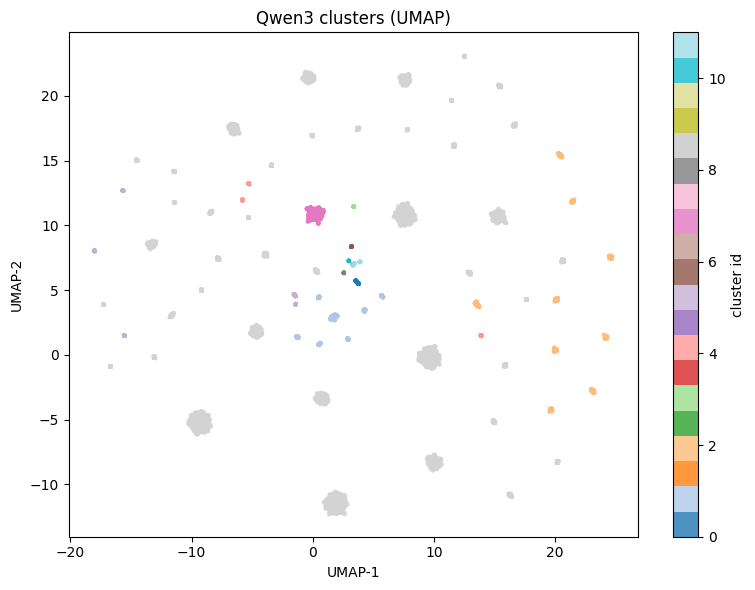

In [27]:
logs_qwen_all = pd.concat([logs_train_qwen_df, logs_test_qwen_df], axis=0)

visualize_clusters_umap(
    logs_df=logs_qwen_all,
    emb_col=EMB_COL_QWEN3,
    cluster_col=CLUSTER_COL_QWEN3,
    sample_size=20_000,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    title="Qwen3 clusters (UMAP)",
)


[visualize_clusters_umap] sampled 20000 rows из 4367049


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


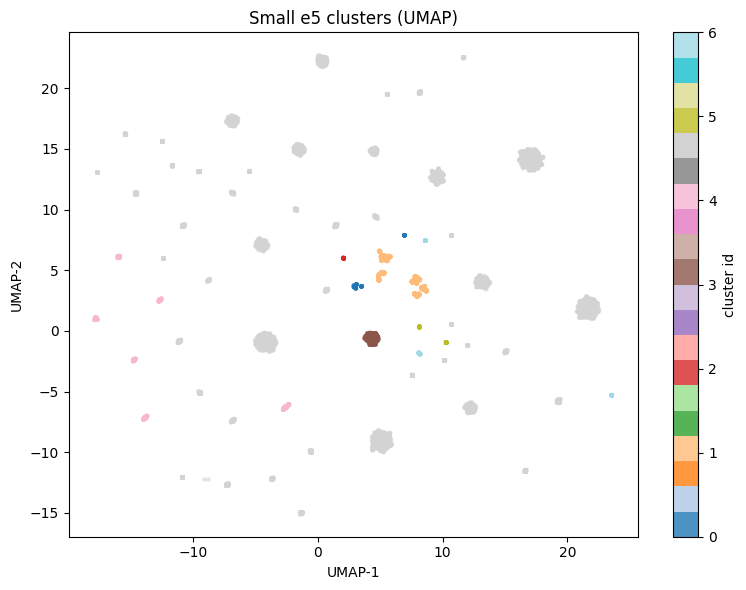

In [36]:
EMB_COL_E5 = "embedding"
CLUSTER_COL_E5 = "cluster_small_e5"

logs_e5_all = pd.concat([logs_train_small_e5_df, logs_test_small_e5_df], axis=0)

visualize_clusters_umap(
    logs_df=logs_e5_all,
    emb_col=EMB_COL_E5,
    cluster_col=CLUSTER_COL_E5,
    sample_size=20_000,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    title="Small e5 clusters (UMAP)",
)


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


def describe_clusters_tfidf(
    df: pd.DataFrame,
    text_col: str,
    cluster_col: str,
    *,
    top_k: int = 10,
    max_features: int = 20_000,
    ngram_range=(1, 2),
    min_df: int = 5,
    sample_per_cluster: int = 5_000,
    drop_noise: bool = True,
) -> dict:
    """
    Строит интерпретацию кластеров через TF-IDF.

    Шаги:
      1) (Опционально) убираем шум-кластер (-1).
      2) Для каждого кластера сэмплируем до sample_per_cluster текстов.
      3) Строим общий TfidfVectorizer по всем выбранным текстам.
      4) Для каждого кластера считаем средний TF-IDF по его документам.
      5) Возвращаем dict: cluster_id -> DataFrame с топ-терминами.

    Параметры:
      text_col        — колонка с текстом (например 'normalized_value')
      cluster_col     — колонка с ID кластера (например 'cluster_qwen3')
      top_k           — сколько топ-терминов на кластер возвращать
      max_features    — максимум признаков в TF-IDF
      ngram_range     — (1,1) только униграммы, (1,2) — уни+биграммы и т.д.
      min_df          — минимум документов, в которых должен встретиться термин
      sample_per_cluster — максимум текстов на кластер для обучения TF-IDF
      drop_noise      — если True, игнорируем кластер -1 (шум)

    Возвращает:
      dict: {cluster_id: pd.DataFrame(columns=['term', 'score'])}
    """
    df_work = df.copy()

    if drop_noise:
        df_work = df_work[df_work[cluster_col] != -1]

    # группируем по кластерам и сэмплируем внутри
    sampled = (
        df_work
        .groupby(cluster_col, group_keys=False)
        .apply(lambda g: g.sample(
            n=min(len(g), sample_per_cluster),
            random_state=42
        ))
    )

    print(f"[describe_clusters_tfidf] sampled rows: {len(sampled)}")

    texts = sampled[text_col].astype(str).tolist()
    clusters = sampled[cluster_col].to_numpy()

    # общий TF-IDF по всем текстам
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=min_df,
    )
    X = vectorizer.fit_transform(texts)  # shape: (n_docs, n_terms)
    terms = np.array(vectorizer.get_feature_names_out())

    result = {}
    unique_clusters = np.unique(clusters)

    for cl in unique_clusters:
        mask = clusters == cl
        if mask.sum() == 0:
            continue

        # avg TF-IDF by cluster documents
        # X[mask] — sparse matrix, mean(axis=0) -> (1, n_terms)
        mean_tfidf = X[mask].mean(axis=0).A1  # -> np.ndarray shape (n_terms,)

        # top-k terms
        top_idx = np.argsort(mean_tfidf)[::-1][:top_k]
        top_terms = terms[top_idx]
        top_scores = mean_tfidf[top_idx]

        result[int(cl)] = pd.DataFrame(
            {"term": top_terms, "score": top_scores}
        )

    return result


In [30]:
TEXT_COL = "normalized_value"
CLUSTER_COL_QWEN3 = "cluster_qwen3"

logs_qwen_all = pd.concat([logs_train_qwen_df, logs_test_qwen_df], axis=0)

qwen3_cluster_terms = describe_clusters_tfidf(
    df=logs_qwen_all,
    text_col=TEXT_COL,
    cluster_col=CLUSTER_COL_QWEN3,
    top_k=15,
    max_features=30_000,
    ngram_range=(1, 2),
    min_df=5,
    sample_per_cluster=5_000,
    drop_noise=True,  # шум -1 не интерпретируем
)

# top terms for 0 cluster
qwen3_cluster_terms[0]


/tmp/ipython-input-526140733.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


[describe_clusters_tfidf] sampled rows: 46782


,term,score
0,num,0.540025
1,num num,0.156451
2,num vchsjnup,0.135868
3,vchsjnup,0.135868
4,product_ids num,0.133871
5,product_ids,0.127545
6,listrecommendations,0.127545
7,listrecommendations product_ids,0.127545
8,recv,0.127545
9,recv listrecommendations,0.127545


In [31]:
for cl, df_terms in qwen3_cluster_terms.items():
    print(f"\nCluster {cl}:")
    print(df_terms.head(10))



=== Cluster 0 ===
                              term     score
0                              num  0.540025
1                          num num  0.156451
2                     num vchsjnup  0.135868
3                         vchsjnup  0.135868
4                  product_ids num  0.133871
5                      product_ids  0.127545
6              listrecommendations  0.127545
7  listrecommendations product_ids  0.127545
8                             recv  0.127545
9         recv listrecommendations  0.127545

=== Cluster 1 ===
                              term     score
0                              num  0.553757
1                          num num  0.179669
2                             recv  0.122799
3                     message recv  0.122799
4         recv listrecommendations  0.122799
5                      product_ids  0.122799
6  listrecommendations product_ids  0.122799
7              listrecommendations  0.122799
8                  product_ids num  0.097945
9                

In [32]:
# CLUSTER_COL_E5 = "cluster_small_e5"

logs_e5_all = pd.concat([logs_train_small_e5_df, logs_test_small_e5_df], axis=0)

e5_cluster_terms = describe_clusters_tfidf(
    df=logs_e5_all,
    text_col=TEXT_COL,
    cluster_col=CLUSTER_COL_E5,
    top_k=15,
    max_features=30_000,
    ngram_range=(1, 2),
    min_df=5,
    sample_per_cluster=5_000,
    drop_noise=True,
)

for cl, df_terms in e5_cluster_terms.items():
    print(f"\n=== Cluster {cl} ===")
    print(df_terms.head(10))


/tmp/ipython-input-526140733.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


[describe_clusters_tfidf] sampled rows: 35000

=== Cluster 0 ===
                 term     score
0                 num  0.546249
1             num num  0.331693
2  dditemasync called  0.116479
3            quantity  0.116479
4           productid  0.116479
5        quantity num  0.116479
6         dditemasync  0.116479
7       num productid  0.106273
8       productid num  0.097292
9                with  0.073043

=== Cluster 1 ===
                              term     score
0                              num  0.511992
1                          num num  0.167339
2                             recv  0.131352
3                      product_ids  0.131352
4         recv listrecommendations  0.131352
5  listrecommendations product_ids  0.131352
6              listrecommendations  0.131352
7                     message recv  0.131352
8                  product_ids num  0.110590
9                     num vchsjnup  0.086412

=== Cluster 2 ===
                   term     score
0               

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


def describe_clusters_tfidf_with_examples(
    df: pd.DataFrame,
    text_col: str,
    cluster_col: str,
    *,
    top_k_terms: int = 10,
    top_examples: int = 5,
    max_features: int = 20_000,
    ngram_range=(1, 2),
    min_df: int = 5,
    sample_per_cluster: int = 5_000,
    drop_noise: bool = True,
    print_output: bool = True,
) -> dict:
    """
    Интерпретация кластеров:
      - TF-IDF по текстам => топ-термины на кластер
      - наиболее частые примеры логов на кластер

    Параметры:
      df              — DataFrame со столбцами text_col и cluster_col
      text_col        — текст логов (например, 'normalized_value')
      cluster_col     — id кластера (напр. 'cluster_qwen3' или 'cluster_e5')
      top_k_terms     — сколько terms показывать на кластер
      top_examples    — сколько примеров логов показывать на кластер
      max_features    — максимум признаков TF-IDF
      ngram_range     — (1,1) только униграммы, (1,2) уни+биграммы и т.д.
      min_df          — минимум документов для термина
      sample_per_cluster — максимум текстов на кластер для TF-IDF
      drop_noise      — исключать ли кластер -1
      print_output    — печатать ли результат в stdout

    Возвращает:
      dict: {
        cluster_id: {
          "terms":    DataFrame(term, score),
          "examples": DataFrame(text_col, count),
        },
        ...
      }
    """
    df_work = df.copy()

    if drop_noise:
        df_work = df_work[df_work[cluster_col] != -1]

    # ========== 1. Частые примеры логов по кластерам ==========
    examples_by_cluster: dict[int, pd.DataFrame] = {}
    for cl, g in df_work.groupby(cluster_col):
        counts = (
            g[text_col]
            .astype(str)
            .value_counts()
            .reset_index()
        )
        counts.columns = [text_col, "count"]
        examples_by_cluster[int(cl)] = counts.head(top_examples)

    # ========== 2. Сэмплирование для TF-IDF ==========
    sampled = (
        df_work
        .groupby(cluster_col, group_keys=False)
        .apply(lambda g: g.sample(
            n=min(len(g), sample_per_cluster),
            random_state=42
        ))
    )

    print(f"[describe_clusters] sampled rows for TF-IDF: {len(sampled)}")

    texts = sampled[text_col].astype(str).tolist()
    clusters = sampled[cluster_col].to_numpy()

    # ========== 3. Общий TF-IDF по всем текстам ==========
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=min_df,
    )
    X = vectorizer.fit_transform(texts)  # (n_docs, n_terms)
    terms = np.array(vectorizer.get_feature_names_out())

    result: dict[int, dict[str, pd.DataFrame]] = {}
    unique_clusters = np.unique(clusters)

    # ========== 4. Для каждого кластера: топ-термины + примеры ==========
    for cl in unique_clusters:
        cl = int(cl)
        mask = clusters == cl
        if mask.sum() == 0:
            continue

        # средний TF-IDF по документам кластера
        mean_tfidf = X[mask].mean(axis=0).A1  # -> (n_terms,)
        top_idx = np.argsort(mean_tfidf)[::-1][:top_k_terms]
        top_terms = terms[top_idx]
        top_scores = mean_tfidf[top_idx]

        df_terms = pd.DataFrame({"term": top_terms, "score": top_scores})
        df_examples = examples_by_cluster.get(cl, pd.DataFrame(columns=[text_col, "count"]))

        result[cl] = {
            "terms": df_terms,
            "examples": df_examples,
        }

        if print_output:
            print(f"\n==================== Cluster {cl} ====================")
            print("Top terms:")
            print(df_terms.head(top_k_terms))

            print("\nMost frequent examples:")
            print(df_examples.head(top_examples))

    return result


In [34]:
TEXT_COL = "normalized_value"
CLUSTER_COL_QWEN3 = "cluster_qwen3"

logs_qwen_all = pd.concat([logs_train_qwen_df, logs_test_qwen_df], axis=0)

qwen3_cluster_desc = describe_clusters_tfidf_with_examples(
    df=logs_qwen_all,
    text_col=TEXT_COL,
    cluster_col=CLUSTER_COL_QWEN3,
    top_k_terms=15,
    top_examples=5,
    max_features=30_000,
    ngram_range=(1, 2),
    min_df=5,
    sample_per_cluster=5_000,
    drop_noise=True,
    print_output=True,
)


/tmp/ipython-input-2623373177.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


[describe_clusters] sampled rows for TF-IDF: 46782

==================== Cluster 0 ====================
Top terms:
                               term     score
0                               num  0.540025
1                           num num  0.156451
2                      num vchsjnup  0.135868
3                          vchsjnup  0.135868
4                   product_ids num  0.133871
5                       product_ids  0.127545
6               listrecommendations  0.127545
7   listrecommendations product_ids  0.127545
8                              recv  0.127545
9          recv listrecommendations  0.127545
10                     message recv  0.127545
11                     vchsjnup num  0.119764
12                    severity info  0.096130
13                             info  0.096130
14                     info message  0.096130

Most frequent examples:
                                    normalized_value  count
0  severity: INFO, message: [Recv ListRecommendat...     21
1  s

In [35]:
CLUSTER_COL_E5 = "cluster_small_e5"

logs_e5_all = pd.concat([logs_train_small_e5_df, logs_test_small_e5_df], axis=0)

e5_cluster_desc = describe_clusters_tfidf_with_examples(
    df=logs_e5_all,
    text_col=TEXT_COL,
    cluster_col=CLUSTER_COL_E5,
    top_k_terms=15,
    top_examples=5,
    max_features=30_000,
    ngram_range=(1, 2),
    min_df=5,
    sample_per_cluster=5_000,
    drop_noise=True,
    print_output=True,
)


/tmp/ipython-input-2623373177.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


[describe_clusters] sampled rows for TF-IDF: 35000

==================== Cluster 0 ====================
Top terms:
                  term     score
0                  num  0.546249
1              num num  0.331693
2   dditemasync called  0.116479
3             quantity  0.116479
4            productid  0.116479
5         quantity num  0.116479
6          dditemasync  0.116479
7        num productid  0.106273
8        productid num  0.097292
9                 with  0.073043
10              userid  0.073043
11              called  0.073043
12         with userid  0.073043
13         called with  0.073043
14          userid num  0.068675

Most frequent examples:
                                    normalized_value  count
0  ddItemAsync called with userId=af<NUM>-b<NUM>c...      2
1  ddItemAsync called with userId=dda<NUM>-<NUM>-...      2
2  ddItemAsync called with userId=<NUM>b<NUM>c<NU...      2
3  ddItemAsync called with userId=cca<NUM>b<NUM>-...      2
4  ddItemAsync called with userI

## Construct log features

In [19]:
# labels with cooldown mask
def labels_with_cooldown_for_features(F: pd.DataFrame,
                                      incidents_df: pd.DataFrame,
                                      pre_minutes: int,
                                      cooldown_minutes: int):
    # index — DatetimeIndex; make Series as expected in build_labels_with_cooldown
    dt_series = pd.Series(F.index, index=F.index)
    y, mask_keep = build_labels_with_cooldown(
        dt=dt_series,
        incidents_df=incidents_df,
        pre_minutes=pre_minutes,
        cooldown_minutes=cooldown_minutes,
    )
    return y, mask_keep

def construct_log_features_multi_windows(
    train_logs_df: pd.DataFrame,
    test_logs_df: pd.DataFrame,
    service_incidents_df: pd.DataFrame,
    *,
    freq: str = "1min",                      # шаг временной сетки агрегации
    roll_windows=("3min", "5min", "10min"),  # rolling-окна по времени
    pre_window_min: int = 15,                # pre-интервал для инцидентов (минуты)
    cooldown_minutes: int = 15,              # длительность серой зоны после инцидента
    cluster_column_name = "cluster"
):
    """
    Строит агрегированные фичи по логам и лейблы c cooldown.

    Вход:
      train_logs_df, test_logs_df: логи (УЖЕ очищенные по cooldown на уровне сырья)
        - обязательно колонка 'datetime'

      service_incidents_df:
        - обязательно колонка 'datetime' с временем инцидентов

    Возвращает:
      F_train_logs: DataFrame c фичами для train (без серых зон)
      F_test_logs:  DataFrame c фичами для test  (без серых зон)
      y_train_logs: 0/1 Series (1 = pre-failure) для train
      y_test_logs:  0/1 Series (1 = pre-failure) для test
    """

    # --- 1. Копии, чтобы не портить исходные датафреймы ---
    train_logs_df = train_logs_df.copy()
    test_logs_df = test_logs_df.copy()

    # --- 2. Биннинг по времени ---
    train_logs_df["datetime_bin"] = train_logs_df["datetime"].dt.floor(freq)
    test_logs_df["datetime_bin"] = test_logs_df["datetime"].dt.floor(freq)

    # --- 3. Counts per cluster per time bin ---
    C_train = (
        train_logs_df
        .groupby(["datetime_bin", cluster_column_name])
        .size()
        .unstack(fill_value=0)
    )
    C_test = (
        test_logs_df
        .groupby(["datetime_bin", cluster_column_name])
        .size()
        .unstack(fill_value=0)
    )

    # Приводим к ровной временной сетке по freq
    C_train = C_train.asfreq(freq, fill_value=0)
    C_test = (
        C_test
        .asfreq(freq, fill_value=0)
        .reindex(columns=C_train.columns, fill_value=0)
    )

    # --- 4. Базовые фичи: просто counts ---
    CNT_tr = C_train.add_prefix("cnt_")
    CNT_te = C_test.add_prefix("cnt_")

    feats_train = [CNT_tr]
    feats_test = [CNT_te]

    # --- 5. Rolling-фичи для каждого окна ---
    for w in roll_windows:
        print(f"[construct_features] rolling window: {w}")

        roll_tr = C_train.rolling(w, min_periods=1)
        roll_te = C_test.rolling(w, min_periods=1)

        # mean
        RM_tr = roll_tr.mean().add_prefix(f"m_{w}_")
        RM_te = roll_te.mean().add_prefix(f"m_{w}_")

        # std
        RS_tr = roll_tr.std().fillna(0).add_prefix(f"s_{w}_")
        RS_te = roll_te.std().fillna(0).add_prefix(f"s_{w}_")

        # variance = std^2
        VAR_tr = (RS_tr ** 2).add_prefix(f"var_{w}_")
        VAR_te = (RS_te ** 2).add_prefix(f"var_{w}_")

        # coefficient of variation: std / mean
        CV_tr_vals = RS_tr.values / (RM_tr.values + 1e-6)
        CV_te_vals = RS_te.values / (RM_te.values + 1e-6)
        CV_tr = pd.DataFrame(
            CV_tr_vals,
            index=C_train.index,
            columns=[c.replace(f"m_{w}_", f"cv_{w}_") for c in RM_tr.columns],
        )
        CV_te = pd.DataFrame(
            CV_te_vals,
            index=C_test.index,
            columns=[c.replace(f"m_{w}_", f"cv_{w}_") for c in RM_te.columns],
        )

        # sum за окно
        SUM_tr = roll_tr.sum().add_prefix(f"sum_{w}_")
        SUM_te = roll_te.sum().add_prefix(f"sum_{w}_")

        # max / min
        MAX_tr = roll_tr.max().add_prefix(f"max_{w}_")
        MAX_te = roll_te.max().add_prefix(f"max_{w}_")

        MIN_tr = roll_tr.min().add_prefix(f"min_{w}_")
        MIN_te = roll_te.min().add_prefix(f"min_{w}_")

        # median
        MED_tr = roll_tr.median().add_prefix(f"med_{w}_")
        MED_te = roll_te.median().add_prefix(f"med_{w}_")

        # z-score: (cnt - mean) / std
        Z_tr_vals = (C_train.values - RM_tr.values) / (RS_tr.values + 1e-6)
        Z_te_vals = (C_test.values - RM_te.values) / (RS_te.values + 1e-6)
        Z_tr = pd.DataFrame(
            Z_tr_vals,
            index=C_train.index,
            columns=[f"z_{w}_{c}" for c in C_train.columns],
        )
        Z_te = pd.DataFrame(
            Z_te_vals,
            index=C_test.index,
            columns=[f"z_{w}_{c}" for c in C_test.columns],
        )

        feats_train += [RM_tr, RS_tr, VAR_tr, CV_tr, SUM_tr, MAX_tr, MIN_tr, MED_tr, Z_tr]
        feats_test  += [RM_te, RS_te, VAR_te, CV_te, SUM_te, MAX_te, MIN_te, MED_te, Z_te]

    # --- 6. First difference по временной сетке (изменение за freq) ---
    D1_tr = C_train.diff().fillna(0).add_prefix("d1_")
    D1_te = C_test.diff().fillna(0).add_prefix("d1_")

    feats_train.append(D1_tr)
    feats_test.append(D1_te)

    # --- 7. Собираем все фичи вместе ---
    F_train_logs = pd.concat(feats_train, axis=1)
    F_test_logs  = pd.concat(feats_test, axis=1)


    # train
    y_train_raw, mask_train = labels_with_cooldown_for_features(
        F_train_logs,
        service_incidents_df,
        pre_minutes=pre_window_min,
        cooldown_minutes=cooldown_minutes,
    )
    # test
    y_test_raw, mask_test = labels_with_cooldown_for_features(
        F_test_logs,
        service_incidents_df,
        pre_minutes=pre_window_min,
        cooldown_minutes=cooldown_minutes,
    )

    # выкидываем серую зону и здесь тоже
    F_train_logs = F_train_logs[mask_train]
    y_train_logs = y_train_raw[mask_train]

    F_test_logs = F_test_logs[mask_test]
    y_test_logs = y_test_raw[mask_test]

    return F_train_logs, F_test_logs, y_train_logs, y_test_logs


In [20]:
X_train_logs_qwen, X_test_logs_qwen, y_train_logs_qwen, y_test_logs_qwen = construct_log_features_multi_windows(
    train_logs_df=logs_train_qwen_df,
    test_logs_df=logs_test_qwen_df,
    service_incidents_df=service_incidents_df,
    freq="1min",
    roll_windows=("3min", "5min", "10min"),
    pre_window_min=PRE_WINDOW_MIN,
    cooldown_minutes=15,
    cluster_column_name = CLUSTER_COL_QWEN3
)
print(f"Feature matrix train: {X_train_logs_qwen.shape}, test: {X_test_logs_qwen.shape}")

[construct_features] rolling window: 3min
[construct_features] rolling window: 5min
[construct_features] rolling window: 10min
Feature matrix train: (861, 377), test: (264, 377)


In [21]:
logs_train_qwen_df['datetime'].nunique()

44190

In [22]:
X_train_logs_small_e5, X_test_logs_small_e5, y_train_logs_small_e5, y_test_logs_small_e5  = construct_log_features_multi_windows(
    train_logs_df=logs_train_small_e5_df,
    test_logs_df=logs_test_small_e5_df,
    service_incidents_df=service_incidents_df,
    freq="1min",
    roll_windows=("3min", "5min", "10min"),
    pre_window_min=PRE_WINDOW_MIN,
    cooldown_minutes=15,
    cluster_column_name = CLUSTER_COL_SMALL_E5
)
print(f"Feature matrix train: {X_train_logs_small_e5.shape}, test: {X_test_logs_small_e5.shape}")

[construct_features] rolling window: 3min
[construct_features] rolling window: 5min
[construct_features] rolling window: 10min
Feature matrix train: (861, 232), test: (264, 232)


In [23]:
# test on correctness
print("logs train min/max:",
      logs_train_qwen_df["datetime"].min(),
      logs_train_qwen_df["datetime"].max())
print("logs test  min/max:",
      logs_test_qwen_df["datetime"].min(),
      logs_test_qwen_df["datetime"].max())


logs train min/max: 2022-05-02 16:00:00 2022-05-03 10:20:59
logs test  min/max: 2022-05-03 10:21:00 2022-05-03 15:59:59


In [24]:
# test on correctness
print("logs train min/max:",
      logs_train_small_e5_df["datetime"].min(),
      logs_train_small_e5_df["datetime"].max())
print("logs test  min/max:",
      logs_test_small_e5_df["datetime"].min(),
      logs_test_small_e5_df["datetime"].max())


logs train min/max: 2022-05-02 16:00:00 2022-05-03 10:20:59
logs test  min/max: 2022-05-03 10:21:00 2022-05-03 15:59:59


## Log baselines

In [27]:
from sklearn.pipeline import Pipeline
log_models_qwen = {
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "naive_bayes": GaussianNB(),
    "knn": KNeighborsClassifier(),
    "logreg": LogisticRegression(max_iter=200, class_weight="balanced"),
}

log_models_qwen["logreg"] = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight="balanced",   # помогает при дисбалансе
        C=0.5                      # сильнее регуляризация
    ))
])
qwen_logs_summary_df_15min_window, details_qwen_15min_window = predict_and_evaluate_robust(log_models_qwen, X_train_logs_qwen, y_train_logs_qwen, X_test_logs_qwen, y_test_logs_qwen, service_incidents_df, 15, fp_per_hour_limit=0.1,
    smooth=None, min_len=None, merge_gap=None, cooldown=None)
qwen_logs_summary_df_15min_window

/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # 

,model,threshold,incident_precision,incident_recall,incident_f1,mean_MTTD,p90_MTTD,TP_incidents,FN_incidents,FP_incidents,FP_per_hour,percentage_of_ones_in_prediction,classic_precision,classic_recall,classic_f1,fp_time_nonwindow_percent
0,naive_bayes,0.5,0.666667,0.190476,0.296296,11.391667,15.000000,4,17,2,0.355030,48.863636,0.178295,0.442308,0.254144,49.763033
1,decision_tree,0.5,0.266667,0.190476,0.222222,7.604167,15.000000,4,17,11,1.952663,26.893939,0.323944,0.442308,0.373984,22.748815
2,knn,0.5,0.192308,0.238095,0.212766,5.990000,13.760000,5,16,21,3.727811,12.878788,0.147059,0.096154,0.116279,13.744076
3,random_forest,0.5,0.250000,0.095238,0.137931,7.391667,12.851667,2,19,6,1.065089,14.393939,0.394737,0.288462,0.333333,10.900474
4,logreg,0.5,0.066667,0.095238,0.078431,6.891667,11.951667,2,19,28,4.970414,32.575758,0.093023,0.153846,0.115942,36.966825


In [28]:
from sklearn.pipeline import Pipeline
log_models_small_e5 = {
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "naive_bayes": GaussianNB(),
    "knn": KNeighborsClassifier(),
    "logreg": LogisticRegression(max_iter=200, class_weight="balanced"),
}
log_models_small_e5["logreg"] = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight="balanced",   # помогает при дисбалансе
        C=0.5                      # сильнее регуляризация
    ))
])
small_e5_logs_summary_df_15min_window, details_small_e5_15min_window = predict_and_evaluate_robust(log_models_small_e5, X_train_logs_small_e5, y_train_logs_small_e5, X_test_logs_small_e5, y_test_logs_small_e5, service_incidents_df, 15, fp_per_hour_limit=0.1,
    smooth=None, min_len=None, merge_gap=None, cooldown=None)
small_e5_logs_summary_df_15min_window

/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # 

,model,threshold,incident_precision,incident_recall,incident_f1,mean_MTTD,p90_MTTD,TP_incidents,FN_incidents,FP_incidents,FP_per_hour,percentage_of_ones_in_prediction,classic_precision,classic_recall,classic_f1,fp_time_nonwindow_percent
0,naive_bayes,0.5,0.800000,0.190476,0.307692,11.391667,15.000000,4,17,1,0.177515,47.727273,0.182540,0.442308,0.258427,48.341232
1,random_forest,0.5,0.428571,0.142857,0.214286,9.894444,14.763333,3,18,4,0.710059,16.287879,0.302326,0.250000,0.273684,14.218009
2,knn,0.5,0.166667,0.190476,0.177778,10.670833,14.465000,4,17,20,3.550296,11.363636,0.200000,0.115385,0.146341,10.900474
3,decision_tree,0.5,0.181818,0.095238,0.125000,14.950000,14.990000,2,19,9,1.597633,25.378788,0.208955,0.269231,0.235294,25.118483
4,logreg,0.5,0.076923,0.095238,0.085106,11.891667,12.951667,2,19,24,4.260355,42.424242,0.116071,0.250000,0.158537,46.445498


In [29]:
import numpy as np
import pandas as pd

def nb_feature_importance(model: GaussianNB, feature_names):
    mu_0 = model.theta_[0]
    mu_1 = model.theta_[1]

    std_0 = np.sqrt(model.var_[0])
    std_1 = np.sqrt(model.var_[1])

    importance = np.abs(mu_1 - mu_0) / (std_0 + std_1 + 1e-8)

    return pd.Series(importance, index=feature_names).sort_values(ascending=False)


In [30]:
nb_model_small_e5 = log_models_small_e5["naive_bayes"]
nb_model_small_e5.fit(X_train_logs_small_e5, y_train_logs_small_e5)

importances = nb_feature_importance(nb_model_small_e5, X_train_logs_small_e5.columns)
importances.head(20)


,0
cnt_-1,0.110645
min_3min_-1,0.101940
cnt_3,0.099711
cnt_1,0.096094
cnt_4,0.095818
min_3min_3,0.094120
m_3min_-1,0.093106
sum_3min_-1,0.092135
sum_3min_3,0.092027
min_3min_4,0.091399


In [31]:
nb_model_qwen3 = log_models_qwen["naive_bayes"]
nb_model_qwen3.fit(X_train_logs_qwen, y_train_logs_qwen)

importances = nb_feature_importance(nb_model_qwen3, X_train_logs_qwen.columns)
importances.head(20)

,0
cnt_-1,0.110849
min_3min_-1,0.102262
cnt_7,0.101170
cnt_2,0.099460
min_3min_7,0.095505
min_3min_2,0.094957
m_3min_-1,0.093360
min_10min_2,0.093342
sum_3min_-1,0.092390
sum_3min_7,0.092215


# Metrics

## Metrics loading

In [32]:
import os
metrics_root = "/content/drive/MyDrive/Aiops-Dataset/data/2022-05-03/metric"

all_metrics = []

for root, dirs, files in os.walk(metrics_root):
    for f in files:
        if f.endswith(".csv"):
            file_path = os.path.join(root, f)
            try:
                df = pd.read_csv(file_path)
                all_metrics.append(df)
            except Exception as e:
                print(f"Error while reading {file_path}: {e}")

# combine all metrics into a single dataframe
metrics_df = pd.concat(all_metrics, ignore_index=True)
print(f"Total metrics: {len(metrics_df):,}")
metrics_df["datetime"] = pd.to_datetime(metrics_df["timestamp"], unit="s")
metrics_df = metrics_df.sort_values("datetime")
metrics_df.head()


Total metrics: 7,614,184


,service,timestamp,rr,sr,mrt,count,cmdb_id,kpi_name,value,datetime
0,paymentservice-grpc,1651507200,100.0,100.0,0.0,0.0,NaN,NaN,NaN,2022-05-02 16:00:00
5528886,NaN,1651507200,NaN,NaN,NaN,NaN,node-5.checkoutservice-1,container_spec_memory_limit_MB,128.0,2022-05-02 16:00:00
5528885,NaN,1651507200,NaN,NaN,NaN,NaN,node-6.frontend2-0,container_spec_memory_limit_MB,128.0,2022-05-02 16:00:00
5528884,NaN,1651507200,NaN,NaN,NaN,NaN,node-5.cartservice-0,container_spec_memory_limit_MB,256.0,2022-05-02 16:00:00
5528883,NaN,1651507200,NaN,NaN,NaN,NaN,node-5.shippingservice-2,container_spec_memory_limit_MB,256.0,2022-05-02 16:00:00


In [33]:
metrics_low_df = metrics_df[metrics_df["cmdb_id"].notna()].copy()
metrics_high_df = metrics_df[metrics_df["cmdb_id"].isna()].copy()
print(metrics_low_df.shape, metrics_high_df.shape)

(7598352, 10) (15832, 10)


In [34]:
## Metrics splitting

In [35]:
def split_metrics_by_cut_ts(
    metrics_df: pd.DataFrame,
    cut_ts: pd.Timestamp,
    datetime_col: str = "datetime",
):
    metrics_df = metrics_df.copy()
    metrics_df[datetime_col] = pd.to_datetime(metrics_df[datetime_col])

    metrics_train_df = metrics_df[metrics_df[datetime_col] < cut_ts]
    metrics_test_df  = metrics_df[metrics_df[datetime_col] >= cut_ts]

    print("Metrics train min/max:",
          metrics_train_df[datetime_col].min(),
          metrics_train_df[datetime_col].max())
    print("Metrics test  min/max:",
          metrics_test_df[datetime_col].min(),
          metrics_test_df[datetime_col].max())

    return metrics_train_df, metrics_test_df

metrics_train_df, metrics_test_df = split_metrics_by_cut_ts(
    metrics_df=metrics_high_df,
    cut_ts=cut_ts2,
    datetime_col="datetime",
)


Metrics train min/max: 2022-05-02 16:00:00 2022-05-03 10:20:00
Metrics test  min/max: 2022-05-03 10:21:00 2022-05-03 15:59:00


## Construct metrics features

In [36]:
import pandas as pd
import numpy as np

def construct_metric_features_multi_windows(
    train_metrics_df: pd.DataFrame,
    test_metrics_df: pd.DataFrame,
    service_incidents_df: pd.DataFrame,
    *,
    datetime_col: str = "datetime",
    service_col: str = "service",
    metric_cols=("rr", "sr", "mrt", "count"),   # какие метрики использовать
    freq: str = "1min",                         # шаг временной сетки агрегации
    roll_windows=("3min", "5min", "10min"),     # rolling-окна по времени
    pre_window_min: int = 15,
    cooldown_minutes: int = 15,
):
    """
    Строит агрегированные фичи по метрикам и лейблы с cooldown (аналогично логам).

    Вход:
      train_metrics_df, test_metrics_df:
        - уже разбиты по cut_ts (тем же, что и логи)
        - обязательно колонки datetime_col и service_col
        - метрики в колонках из metric_cols (например rr/sr/mrt/count)

      service_incidents_df:
        - обязательно колонка datetime_col с временем инцидентов

    Возвращает:
      F_train_metrics: DataFrame c фичами для train (без серых зон)
      F_test_metrics:  DataFrame c фичами для test  (без серых зон)
      y_train_metrics: 0/1 Series (1 = pre-failure) для train
      y_test_metrics:  0/1 Series (1 = pre-failure) для test
    """

    # --- 1. Копии, чтобы не портить исходные датафреймы ---
    train = train_metrics_df.copy()
    test = test_metrics_df.copy()

    train[datetime_col] = pd.to_datetime(train[datetime_col])
    test[datetime_col]  = pd.to_datetime(test[datetime_col])

    # --- 2. Биннинг по времени ---
    train["datetime_bin"] = train[datetime_col].dt.floor(freq)
    test["datetime_bin"]  = test[datetime_col].dt.floor(freq)

    # --- 3. Минутная агрегация по (datetime_bin, service) ---
    # rr/sr/mrt — среднее, count — сумма
    agg_spec = {}
    for col in metric_cols:
        if col == "count":
            agg_spec[col] = "sum"
        else:
            agg_spec[col] = "mean"

    M_train = (
        train
        .groupby(["datetime_bin", service_col])[list(metric_cols)]
        .agg(agg_spec)
        .unstack(fill_value=0)
    )
    M_test = (
        test
        .groupby(["datetime_bin", service_col])[list(metric_cols)]
        .agg(agg_spec)
        .unstack(fill_value=0)
    )

    # Приводим к ровной временной сетке по freq
    M_train = M_train.asfreq(freq, fill_value=0)
    M_test = (
        M_test
        .asfreq(freq, fill_value=0)
        .reindex(columns=M_train.columns, fill_value=0)
    )

    # --- 4. Прямые метрики как базовые фичи ---
    # колонка вида (metric, service) -> "metric_service"
    M_train.columns = [f"{metric}_{svc}" for metric, svc in M_train.columns]
    M_test.columns  = [f"{metric}_{svc}" for metric, svc in M_test.columns]

    feats_train = [M_train]
    feats_test  = [M_test]

    # --- 5. Rolling-фичи для каждого окна (как в логах) ---
    for w in roll_windows:
        print(f"[construct_metric_features] rolling window: {w}")

        roll_tr = M_train.rolling(w, min_periods=1)
        roll_te = M_test.rolling(w, min_periods=1)

        # mean
        RM_tr = roll_tr.mean().add_prefix(f"m_{w}_")
        RM_te = roll_te.mean().add_prefix(f"m_{w}_")

        # std
        RS_tr = roll_tr.std().fillna(0).add_prefix(f"s_{w}_")
        RS_te = roll_te.std().fillna(0).add_prefix(f"s_{w}_")

        # variance (var)
        VAR_tr = roll_tr.var().fillna(0).add_prefix(f"var_{w}_")
        VAR_te = roll_te.var().fillna(0).add_prefix(f"var_{w}_")

        # coefficient of variation: std / mean
        CV_tr_vals = RS_tr.values / (RM_tr.values + 1e-6)
        CV_te_vals = RS_te.values / (RM_te.values + 1e-6)
        CV_tr = pd.DataFrame(
            CV_tr_vals,
            index=M_train.index,
            columns=[c.replace(f"m_{w}_", f"cv_{w}_") for c in RM_tr.columns],
        )
        CV_te = pd.DataFrame(
            CV_te_vals,
            index=M_test.index,
            columns=[c.replace(f"m_{w}_", f"cv_{w}_") for c in RM_te.columns],
        )

        # sum
        SUM_tr = roll_tr.sum().add_prefix(f"sum_{w}_")
        SUM_te = roll_te.sum().add_prefix(f"sum_{w}_")

        # max / min / median
        MAX_tr = roll_tr.max().add_prefix(f"max_{w}_")
        MAX_te = roll_te.max().add_prefix(f"max_{w}_")

        MIN_tr = roll_tr.min().add_prefix(f"min_{w}_")
        MIN_te = roll_te.min().add_prefix(f"min_{w}_")

        MED_tr = roll_tr.median().add_prefix(f"med_{w}_")
        MED_te = roll_te.median().add_prefix(f"med_{w}_")

        # z-score: (value - mean)/std, по базовым метрикам M_train/M_test
        Z_tr_vals = (M_train.values - RM_tr.values) / (RS_tr.values + 1e-6)
        Z_te_vals = (M_test.values - RM_te.values) / (RS_te.values + 1e-6)
        Z_tr = pd.DataFrame(
            Z_tr_vals,
            index=M_train.index,
            columns=[f"z_{w}_{c}" for c in M_train.columns],
        )
        Z_te = pd.DataFrame(
            Z_te_vals,
            index=M_test.index,
            columns=[f"z_{w}_{c}" for c in M_test.columns],
        )

        feats_train += [RM_tr, RS_tr, VAR_tr, CV_tr, SUM_tr, MAX_tr, MIN_tr, MED_tr, Z_tr]
        feats_test  += [RM_te, RS_te, VAR_te, CV_te, SUM_te, MAX_te, MIN_te, MED_te, Z_te]

    # --- 6. First difference (изменение за freq) ---
    D1_tr = M_train.diff().fillna(0).add_prefix("d1_")
    D1_te = M_test.diff().fillna(0).add_prefix("d1_")

    feats_train.append(D1_tr)
    feats_test.append(D1_te)

    # --- 7. Собираем все фичи ---
    F_train_metrics = pd.concat(feats_train, axis=1)
    F_test_metrics  = pd.concat(feats_test, axis=1)

    # --- 8. Лейблы + cooldown на уровне агрегатов ---
    y_train_raw, mask_train = labels_with_cooldown_for_features(
        F_train_metrics,
        service_incidents_df,
        pre_minutes=pre_window_min,
        cooldown_minutes=cooldown_minutes,
    )

    y_test_raw, mask_test = labels_with_cooldown_for_features(
        F_test_metrics,
        service_incidents_df,
        pre_minutes=pre_window_min,
        cooldown_minutes=cooldown_minutes,
    )

    # выкидываем серую зону
    F_train_metrics = F_train_metrics[mask_train]
    y_train_metrics = y_train_raw[mask_train]

    F_test_metrics = F_test_metrics[mask_test]
    y_test_metrics = y_test_raw[mask_test]

    return F_train_metrics, F_test_metrics, y_train_metrics, y_test_metrics


In [37]:
X_train_metrics, X_test_metrics, y_train_metrics, y_test_metrics = (
    construct_metric_features_multi_windows(
        train_metrics_df=metrics_train_df,
        test_metrics_df=metrics_test_df,
        service_incidents_df=service_incidents_df,
        datetime_col="datetime",
        service_col="service",
        metric_cols=("rr", "sr", "mrt", "count"),
        freq="1min",
        roll_windows=("3min", "5min", "10min"),
        pre_window_min=PRE_MINUTES,
        cooldown_minutes=COOLDOWN_MINUTES,
    )
)
print(f"Feature matrix train: {X_train_metrics.shape}, test: {X_test_metrics.shape}")

[construct_metric_features] rolling window: 3min
[construct_metric_features] rolling window: 5min
[construct_metric_features] rolling window: 10min
Feature matrix train: (861, 1276), test: (264, 1276)


In [38]:
X_test_metrics.head()

,rr_adservice-grpc,rr_adservice-http,rr_cartservice-grpc,rr_checkoutservice-grpc,rr_currencyservice-grpc,rr_emailservice-grpc,rr_frontend-http,rr_paymentservice-grpc,rr_productcatalogservice-grpc,rr_recommendationservice-grpc,...,d1_count_adservice-http,d1_count_cartservice-grpc,d1_count_checkoutservice-grpc,d1_count_currencyservice-grpc,d1_count_emailservice-grpc,d1_count_frontend-http,d1_count_paymentservice-grpc,d1_count_productcatalogservice-grpc,d1_count_recommendationservice-grpc,d1_count_shippingservice-grpc
datetime_bin,,,,,,,,,,,,,,,,,,,,,
2022-05-03 10:21:00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-03 10:22:00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,10.0,4.0,2.0,4.0,5.0,0.0,149.0,-1.0,42.0
2022-05-03 10:23:00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,14.0,-5.0,59.0,1.0,21.0,2.0,-50.0,18.0,-53.0
2022-05-03 10:24:00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,14.0,7.0,19.0,-1.0,1.0,1.0,141.0,-5.0,73.0
2022-05-03 10:25:00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,-47.0,-9.0,-79.0,0.0,-21.0,-4.0,-282.0,-19.0,-86.0


In [39]:
metric_models = {
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "naive_bayes": GaussianNB(),
    "knn": KNeighborsClassifier(),
    "logreg": LogisticRegression(max_iter=200, class_weight="balanced"),
}

metric_models["logreg"] = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight="balanced",   # помогает при дисбалансе
        C=0.5                      # сильнее регуляризация
    ))
])
metrics_summary_df_15min_window, details_only_metrics_used_15min_window = predict_and_evaluate_robust(metric_models, X_train_metrics, y_train_metrics, X_test_metrics, y_test_metrics, service_incidents_df, 15, fp_per_hour_limit=0.1,
    smooth=None, min_len=None, merge_gap=None, cooldown=None)
metrics_summary_df_15min_window

/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # 

,model,threshold,incident_precision,incident_recall,incident_f1,mean_MTTD,p90_MTTD,TP_incidents,FN_incidents,FP_incidents,FP_per_hour,percentage_of_ones_in_prediction,classic_precision,classic_recall,classic_f1,fp_time_nonwindow_percent
0,naive_bayes,0.5,0.625000,0.238095,0.344828,13.180000,15.000000,5,16,3,0.532544,83.333333,0.159091,0.673077,0.257353,87.203791
1,decision_tree,0.5,0.307692,0.190476,0.235294,9.683333,14.970000,4,17,9,1.597633,63.636364,0.160714,0.519231,0.245455,66.350711
2,logreg,0.5,0.130435,0.142857,0.136364,10.038889,14.643333,3,18,20,3.550296,39.393939,0.153846,0.307692,0.205128,41.706161
3,knn,0.5,0.050000,0.047619,0.048780,6.900000,6.900000,1,20,19,3.372781,26.515152,0.057143,0.076923,0.065574,31.279621
4,random_forest,0.5,0.000000,0.000000,0.000000,NaN,NaN,0,21,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
nb_model_metrics = metric_models["naive_bayes"]
nb_model_small_e5.fit(X_train_metrics, y_train_metrics)

importances = nb_feature_importance(nb_model_metrics, X_train_metrics.columns)
importances.head(20)


,0
var_10min_mrt_recommendationservice-grpc,0.223502
sum_10min_sr_adservice-grpc,0.219549
sum_10min_mrt_recommendationservice-grpc,0.214136
var_10min_mrt_adservice-http,0.212879
max_10min_mrt_recommendationservice-grpc,0.206373
var_10min_count_frontend-http,0.194992
min_10min_mrt_currencyservice-grpc,0.191429
sum_10min_mrt_adservice-http,0.185378
sum_5min_sr_adservice-grpc,0.179726
var_10min_count_productcatalogservice-grpc,0.178016


# Metrics with logs

In [41]:
def combine_log_and_metric_features(
    F_train_logs: pd.DataFrame,
    y_train_logs: pd.Series,
    F_test_logs: pd.DataFrame,
    y_test_logs: pd.Series,
    F_train_metrics: pd.DataFrame,
    y_train_metrics: pd.Series,
    F_test_metrics: pd.DataFrame,
    y_test_metrics: pd.Series,
):
    """
    Объединяет логовые и метриковые фичи по времени и выравнивает y.
    Предполагается, что индекс F_* — DatetimeIndex.

    Возвращает:
      F_train_combined, F_test_combined, y_train_combined, y_test_combined,
      scaler (или None, если scale=False)
    """

    # 1) inner-join по времени: оставляем только те таймстемпы,
    # которые есть и в логах, и в метриках
    F_train_combined = F_train_logs.join(F_train_metrics, how="inner", rsuffix="_metric")
    F_test_combined  = F_test_logs.join(F_test_metrics,  how="inner", rsuffix="_metric")

    # 2) выравниваем y по индексу объединённых фич
    train_idx = F_train_combined.index
    test_idx  = F_test_combined.index

    # берём y из логов (при желании можно ассертом проверить совпадение с y по метрикам)
    y_train_combined = y_train_logs.reindex(train_idx)
    y_test_combined  = y_test_logs.reindex(test_idx)

    # на всякий случай проверим, что нет NaN в y
    assert not y_train_combined.isna().any(), "NaN в y_train_combined"
    assert not y_test_combined.isna().any(), "NaN в y_test_combined"

    scaler = None
    # if scale:
    #     scaler = StandardScaler()
    #     X_train_scaled = scaler.fit_transform(F_train_combined)
    #     X_test_scaled  = scaler.transform(F_test_combined)

    #     F_train_combined = pd.DataFrame(
    #         X_train_scaled, index=train_idx, columns=F_train_combined.columns
    #     )
    #     F_test_combined = pd.DataFrame(
    #         X_test_scaled, index=test_idx, columns=F_test_combined.columns
    #     )

    return F_train_combined, F_test_combined, y_train_combined, y_test_combined, scaler


In [42]:
X_train_combined_small_e5, X_test_combined_small_e5, \
y_train_combined_small_e5, y_test_combined_small_e5, \
scaler_small_e5 = combine_log_and_metric_features(
    F_train_logs=X_train_logs_small_e5,
    y_train_logs=y_train_logs_small_e5,
    F_test_logs=X_test_logs_small_e5,
    y_test_logs=y_test_logs_small_e5,
    F_train_metrics=X_train_metrics,
    y_train_metrics=y_train_metrics,
    F_test_metrics=X_test_metrics,
    y_test_metrics=y_test_metrics,
)
print(f"Feature matrix train: {X_train_combined_small_e5.shape}, test: {X_test_combined_small_e5.shape}")


Feature matrix train: (861, 1508), test: (264, 1508)


In [43]:
metrics_with_log_models_small_e5 = {
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "naive_bayes": GaussianNB(),
    "knn": KNeighborsClassifier(),
    "logreg": LogisticRegression(max_iter=200, class_weight="balanced"),
}

metrics_with_log_models_small_e5["logreg"] = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight="balanced",   # помогает при дисбалансе
        C=0.5                      # сильнее регуляризация
    ))
])

summary_logs_with_metrics_df_small_e5_15min_window, \
details_metrics_with_small_e5_logs_combined_15min_window = predict_and_evaluate_robust(
    metrics_with_log_models_small_e5,
    X_train_combined_small_e5,
    y_train_combined_small_e5,
    X_test_combined_small_e5,
    y_test_combined_small_e5,
    service_incidents_df,
    15,
    fp_per_hour_limit=0.1,
    smooth=None, min_len=None, merge_gap=None, cooldown=None
)

summary_logs_with_metrics_df_small_e5_15min_window


/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # 

,model,threshold,incident_precision,incident_recall,incident_f1,mean_MTTD,p90_MTTD,TP_incidents,FN_incidents,FP_incidents,FP_per_hour,percentage_of_ones_in_prediction,classic_precision,classic_recall,classic_f1,fp_time_nonwindow_percent
0,decision_tree,0.5,0.294118,0.238095,0.263158,10.746667,15.000000,5,16,12,2.130178,32.196970,0.294118,0.480769,0.364964,28.436019
1,naive_bayes,0.5,0.300000,0.142857,0.193548,15.000000,15.000000,3,18,7,1.242604,47.348485,0.168000,0.403846,0.237288,48.815166
2,knn,0.5,0.120000,0.142857,0.130435,9.561111,14.163333,3,18,22,3.905325,14.393939,0.236842,0.173077,0.200000,13.744076
3,logreg,0.5,0.076923,0.047619,0.058824,13.216667,13.216667,1,20,12,2.130178,30.681818,0.148148,0.230769,0.180451,32.227488
4,random_forest,0.5,0.000000,0.000000,0.000000,NaN,NaN,0,21,1,0.177515,1.136364,0.000000,0.000000,0.000000,1.421801


In [44]:
X_train_combined_qwen3, X_test_combined_qwen3, \
y_train_combined_qwen3, y_test_combined_qwen3, \
scaler_qwen3 = combine_log_and_metric_features(
    F_train_logs=X_train_logs_qwen,
    y_train_logs=y_train_logs_qwen,
    F_test_logs=X_test_logs_qwen,
    y_test_logs=y_test_logs_qwen,
    F_train_metrics=X_train_metrics,
    y_train_metrics=y_train_metrics,
    F_test_metrics=X_test_metrics,
    y_test_metrics=y_test_metrics
)

print(f"Feature matrix train: {X_train_combined_qwen3.shape}, test: {X_test_combined_qwen3.shape}")

Feature matrix train: (861, 1653), test: (264, 1653)


In [48]:
metrics_with_log_models_qwen = {
    "decision_tree": DecisionTreeClassifier(random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "naive_bayes": GaussianNB(),
    "knn": KNeighborsClassifier(),
    "logreg": LogisticRegression(max_iter=200, class_weight="balanced"),
}

metrics_with_log_models_qwen["logreg"] = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight="balanced",   # помогает при дисбалансе
        C=0.5                      # сильнее регуляризация
    ))
])

summary_logs_with_metrics_df_qwen_15min_window, details_metrics_with_qwen_logs_combined_15min_window = predict_and_evaluate_robust(
    metrics_with_log_models_qwen,
    X_train_combined_qwen3,
    y_train_combined_qwen3,
    X_test_combined_qwen3,
    y_test_combined_qwen3,
    service_incidents_df,
    15,
    fp_per_hour_limit=0.1,
    smooth=None, min_len=None, merge_gap=None, cooldown=None
)

summary_logs_with_metrics_df_qwen_15min_window

/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # 

,model,threshold,incident_precision,incident_recall,incident_f1,mean_MTTD,p90_MTTD,TP_incidents,FN_incidents,FP_incidents,FP_per_hour,percentage_of_ones_in_prediction,classic_precision,classic_recall,classic_f1,fp_time_nonwindow_percent
0,decision_tree,0.5,0.307692,0.190476,0.235294,9.683333,14.970000,4,17,9,1.597633,25.757576,0.308824,0.403846,0.350000,22.274882
1,knn,0.5,0.172414,0.238095,0.200000,8.790000,14.960000,5,16,24,4.260355,17.424242,0.239130,0.211538,0.224490,16.587678
2,naive_bayes,0.5,0.272727,0.142857,0.187500,15.000000,15.000000,3,18,8,1.420118,48.106061,0.165354,0.403846,0.234637,49.763033
3,logreg,0.5,0.047619,0.047619,0.047619,13.216667,13.216667,1,20,20,3.550296,36.363636,0.145833,0.269231,0.189189,38.388626
4,random_forest,0.5,0.000000,0.000000,0.000000,NaN,NaN,0,21,1,0.177515,0.378788,0.000000,0.000000,0.000000,0.473934


In [51]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_combined_small_e5, y_train_combined_small_e5)


importances = pd.Series(
    dt.feature_importances_,
    index=X_train_combined_small_e5.columns
).sort_values(ascending=False)

importances.head(20)


,0
m_10min_mrt_recommendationservice-grpc,0.149764
max_10min_mrt_recommendationservice-grpc,0.097783
s_10min_mrt_adservice-http,0.075510
min_10min_count_productcatalogservice-grpc,0.069494
cv_10min_count_productcatalogservice-grpc,0.068095
sum_10min_mrt_cartservice-grpc,0.057591
max_5min_count_currencyservice-grpc,0.046840
cv_10min_mrt_frontend-http,0.045337
max_10min_mrt_currencyservice-grpc,0.044991
max_10min_mrt_adservice-http,0.038574


In [50]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_combined_qwen3, y_train_combined_qwen3)

importances = pd.Series(
    dt.feature_importances_,
    index=X_train_combined_qwen3.columns
).sort_values(ascending=False)

importances.head(20)


,0
m_10min_mrt_recommendationservice-grpc,0.149764
max_10min_mrt_adservice-http,0.114084
max_10min_mrt_recommendationservice-grpc,0.097783
min_10min_count_productcatalogservice-grpc,0.069494
cv_10min_count_productcatalogservice-grpc,0.068095
m_10min_mrt_cartservice-grpc,0.057591
s_5min_count_currencyservice-grpc,0.046840
cv_10min_mrt_frontend-http,0.045337
max_10min_mrt_currencyservice-grpc,0.044991
s_10min_0,0.044436


# TS2Vec

In [23]:
!pip uninstall -y pypots
!pip install git+https://github.com/arinagoncharova2005/PyPOTS.git

Found existing installation: pypots 1.0
Uninstalling pypots-1.0:
  Successfully uninstalled pypots-1.0
  Cloning https://github.com/arinagoncharova2005/PyPOTS.git to /tmp/pip-req-build-m3c8qnmt
  Running command git clone --filter=blob:none --quiet https://github.com/arinagoncharova2005/PyPOTS.git /tmp/pip-req-build-m3c8qnmt
  Resolved https://github.com/arinagoncharova2005/PyPOTS.git to commit b8a453cfaf5e2b3425ce3e8ea407974838f75435
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pypots: filename=pypots-1.0-py3-none-any.whl size=750009 sha256=5e68ef6d9c65468738b16d4191e77120e057243c21cea0beac4dc808aa6ff64a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c27jc0p8/wheels/69/d8/23/926a1469ecd1b911d224ff3755d2b9c55ce1a0294584c70549
Successfully built pypots


In [24]:
from pypots.representation.ts2vec import TS2Vec  # <- use this class
TS2VEC_BACKEND = "pypots"
ENTITY_COL = "cmdb_id"  # or "service"
FREQ = "1min"


████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [25]:
# rotating metrics matrix

# Параметры
FREQ = "1min"  # интервал ресемплинга
METRIC_COLS = ['rr', 'sr', 'mrt', 'count']

# Подготовка
m2 = metrics_high_df.copy()
# m2['datetime'] = pd.to_datetime(m2['datetime'])
m2 = m2.set_index('datetime')

# Только нужные колонки
m2 = m2[['service'] + METRIC_COLS]

# Группировка по service и ресемплинг
# Используем groupby + resample via pd.Grouper
grouped = m2.groupby('service').resample(FREQ).mean()

# После resample, индекс — MultiIndex: (service, datetime)
grouped = grouped.reset_index(level='service')

# Pivot: строка = datetime, колонки = service × метрика
metrics_wide_df = (
    grouped
    .pivot_table(
        index='datetime',
        columns='service',
        values=METRIC_COLS,
        aggfunc='mean'
    )
)

# Если требуется, flatten многоуровневые колонки
metrics_wide_df.columns = [
    f"{svc}_{metr}"
    for svc, metr in metrics_wide_df.columns
]

# # Интерполяция во времени (upsample/forward-fill/backfill)
# metrics_wide_df = (
#     metrics_wide_df
#     .sort_index()
#     .interpolate(method='time', limit_direction='both')
# )

metrics_wide_df.head()


,count_adservice-grpc,count_adservice-http,count_cartservice-grpc,count_checkoutservice-grpc,count_currencyservice-grpc,count_emailservice-grpc,count_frontend-http,count_paymentservice-grpc,count_productcatalogservice-grpc,count_recommendationservice-grpc,...,sr_adservice-http,sr_cartservice-grpc,sr_checkoutservice-grpc,sr_currencyservice-grpc,sr_emailservice-grpc,sr_frontend-http,sr_paymentservice-grpc,sr_productcatalogservice-grpc,sr_recommendationservice-grpc,sr_shippingservice-grpc
datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-02 16:00:00,113.0,24.0,113.0,0.0,343.0,0.0,115.0,0.0,620.0,97.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2022-05-02 16:01:00,113.0,24.0,113.0,0.0,343.0,0.0,115.0,0.0,620.0,97.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2022-05-02 16:02:00,44.0,24.0,133.0,9.0,428.0,8.0,141.0,7.0,744.0,87.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2022-05-02 16:03:00,103.0,24.0,108.0,1.0,339.0,2.0,117.0,3.0,639.0,95.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2022-05-02 16:04:00,49.0,24.0,134.0,9.0,455.0,7.0,133.0,7.0,717.0,87.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [26]:
# rotating logs matrix
logs_e5_all = pd.concat([logs_train_small_e5_df, logs_test_small_e5_df], axis=0)
l = logs_e5_all[['cmdb_id', 'datetime', CLUSTER_COL_SMALL_E5]].copy()
l['datetime'] = pd.to_datetime(l['datetime'], errors='coerce')

log_counts = (
    l.groupby(['cmdb_id', pd.Grouper(key='datetime', freq=FREQ), CLUSTER_COL_SMALL_E5])
     .size().rename('count').reset_index()
)

logs_wide_df = (
    log_counts
     .pivot_table(index='datetime',
                  columns=['cmdb_id', CLUSTER_COL_SMALL_E5],
                  values='count',
                  aggfunc='sum',
                  fill_value=0)
     .sort_index()
)

# плоские имена колонок: ('frontend-1', 23) -> 'cmdb_frontend-1__cluster_23'
logs_wide_df.columns = [f"cmdb_{cmdb}__cluster_{cl}" for (cmdb, cl) in logs_wide_df.columns]
logs_wide_df.head()

,cmdb_adservice-0__cluster_-1,cmdb_adservice-0__cluster_4,cmdb_cartservice-0__cluster_-1,cmdb_cartservice-0__cluster_0,cmdb_cartservice-0__cluster_2,cmdb_cartservice-0__cluster_3,cmdb_cartservice-1__cluster_-1,cmdb_cartservice-1__cluster_0,cmdb_cartservice-1__cluster_2,cmdb_cartservice-1__cluster_3,...,cmdb_recommendationservice-1__cluster_-1,cmdb_recommendationservice-1__cluster_1,cmdb_recommendationservice-2__cluster_1,cmdb_redis-cart-0__cluster_-1,cmdb_shippingservice-0__cluster_-1,cmdb_shippingservice-0__cluster_6,cmdb_shippingservice-1__cluster_-1,cmdb_shippingservice-1__cluster_6,cmdb_shippingservice-2__cluster_-1,cmdb_shippingservice-2__cluster_6
datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-02 16:00:00,364,156,216,0,0,27,224,2,0,26,...,0,20,18,0,2,0,2,0,2,0
2022-05-02 16:01:00,168,72,216,5,0,22,224,2,1,25,...,0,22,24,0,24,0,20,0,23,1
2022-05-02 16:02:00,336,144,240,0,2,28,224,0,1,27,...,0,20,19,0,9,3,9,1,6,2
2022-05-02 16:03:00,182,78,232,3,1,25,248,6,1,24,...,0,22,23,0,21,1,24,2,22,0
2022-05-02 16:04:00,308,132,232,2,1,26,232,0,2,27,...,0,21,22,0,8,0,6,2,14,2


In [27]:
idx = metrics_wide_df.index.union(logs_wide_df.index)
metrics_wide_df = (metrics_wide_df
                   .reindex(idx)
                   .interpolate(method='time', limit_direction='both'))
logs_wide_df = logs_wide_df.reindex(idx).fillna(0)

X_all = (metrics_wide_df.join(logs_wide_df, how='outer')
         .sort_index()
         .fillna(0))

X_all.head()

,count_adservice-grpc,count_adservice-http,count_cartservice-grpc,count_checkoutservice-grpc,count_currencyservice-grpc,count_emailservice-grpc,count_frontend-http,count_paymentservice-grpc,count_productcatalogservice-grpc,count_recommendationservice-grpc,...,cmdb_recommendationservice-1__cluster_-1,cmdb_recommendationservice-1__cluster_1,cmdb_recommendationservice-2__cluster_1,cmdb_redis-cart-0__cluster_-1,cmdb_shippingservice-0__cluster_-1,cmdb_shippingservice-0__cluster_6,cmdb_shippingservice-1__cluster_-1,cmdb_shippingservice-1__cluster_6,cmdb_shippingservice-2__cluster_-1,cmdb_shippingservice-2__cluster_6
datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-02 16:00:00,113.0,24.0,113.0,0.0,343.0,0.0,115.0,0.0,620.0,97.0,...,0.0,20.0,18.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0
2022-05-02 16:01:00,113.0,24.0,113.0,0.0,343.0,0.0,115.0,0.0,620.0,97.0,...,0.0,22.0,24.0,0.0,24.0,0.0,20.0,0.0,23.0,1.0
2022-05-02 16:02:00,44.0,24.0,133.0,9.0,428.0,8.0,141.0,7.0,744.0,87.0,...,0.0,20.0,19.0,0.0,9.0,3.0,9.0,1.0,6.0,2.0
2022-05-02 16:03:00,103.0,24.0,108.0,1.0,339.0,2.0,117.0,3.0,639.0,95.0,...,0.0,22.0,23.0,0.0,21.0,1.0,24.0,2.0,22.0,0.0
2022-05-02 16:04:00,49.0,24.0,134.0,9.0,455.0,7.0,133.0,7.0,717.0,87.0,...,0.0,21.0,22.0,0.0,8.0,0.0,6.0,2.0,14.0,2.0


In [28]:
X_all_std = (X_all - X_all.mean()) / (X_all.std().replace(0,1))

In [29]:
def split_X_with_cooldown_by_cut_ts(
    X_all: pd.DataFrame,
    incidents_df: pd.DataFrame,
    cut_ts,
    pre_minutes: int = 15,
    cooldown_minutes: int = 15,
):
    """
    Делает:
      1) build_labels_with_cooldown по индексу X_all
      2) time-based split по cut_ts
      3) выкидывает cooldown-зоны отдельно в train и test

    Параметры:
        X_all        -- DataFrame с фичами, индекс = DatetimeIndex (или приводимый к нему)
        incidents_df -- DataFrame с колонкой 'datetime' (инциденты)
        cut_ts       -- Timestamp / строка с датой (граница train/test)
        pre_minutes  -- окно pre-failure
        cooldown_minutes -- длина cooldown зоны

    Возвращает:
        X_train, X_test, y_train, y_test
    """
    # build labels with keep mask
    y, keep = build_labels_with_cooldown(
        dt=X_all.index,
        incidents_df=incidents_df,
        pre_minutes=pre_minutes,
        cooldown_minutes=cooldown_minutes,
    )

    # time-based split on cut_ts
    cut_ts = pd.to_datetime(cut_ts)
    idx = X_all.index

    mask_train_time = idx < cut_ts
    mask_test_time  = idx >= cut_ts

    # use cooldown
    train_mask = mask_train_time & keep
    test_mask  = mask_test_time & keep

    X_train = X_all.loc[train_mask]
    y_train = y.loc[train_mask]

    X_test = X_all.loc[test_mask]
    y_test = y.loc[test_mask]

    print("Train time range:", X_train.index.min(), "→", X_train.index.max())
    print("Test  time range:", X_test.index.min(),  "→", X_test.index.max())
    print("Train size:", len(X_train), "Test size:", len(X_test))

    return X_train, X_test, y_train, y_test


In [30]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = split_X_with_cooldown_by_cut_ts(
    X_all=X_all_std,
    incidents_df=service_incidents_df,
    cut_ts=cut_ts2,
    pre_minutes=PRE_MINUTES,
    cooldown_minutes=COOLDOWN_MINUTES,
)


Train time range: 2022-05-02 16:00:00 → 2022-05-03 10:20:00
Test  time range: 2022-05-03 10:21:00 → 2022-05-03 15:59:00
Train size: 861 Test size: 264


In [31]:
from pypots.representation.ts2vec import TS2Vec


T_train, C = X_train_combined.shape
T_test  = X_test_combined.shape[0]

ts_train = X_train_combined.to_numpy(dtype=np.float32).T[:, :, None]  # (N, T, 1)
ts_test  = X_test_combined.to_numpy(dtype=np.float32).T[:, :, None]   # (N, T, 1)
ts_train.shape, ts_test.shape


((96, 861, 1), (96, 264, 1))

In [32]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:

ts2vec = TS2Vec(
    n_steps=T_train,      # timestamp length
    n_features=1,         # channels
    n_output_dims=128,    # emb size
    d_hidden=64,
    n_layers=4,
    batch_size=16,
    epochs=100,
    device=device,
    verbose=True,
)
ts2vec.fit({'X': ts_train})


2025-12-03 19:01:48 [INFO]: Using the given device: cuda
2025-12-03 19:01:48 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-12-03 19:01:49 [INFO]: TS2Vec initialized with the given hyperparameters, the number of trainable parameters: 181,248
2025-12-03 19:01:53 [INFO]: Epoch 001 - training loss (default): 10.5532
2025-12-03 19:01:54 [INFO]: Epoch 002 - training loss (default): 4.1278
2025-12-03 19:01:55 [INFO]: Epoch 003 - training loss (default): 3.5445
2025-12-03 19:01:55 [INFO]: Epoch 004 - training loss (default): 3.6219
2025-12-03 19:01:56 [INFO]: Epoch 005 - training loss (default): 3.8631
2025-12-03 19:01:56 [INFO]: Epoch 006 - training loss (default): 3.3406
2025-12-03 19:01:57 [INFO]: Epoch 007 - training loss (default): 3.5512
2025-12-03 19:01:57 [INFO]: Epoch 008 - training loss (default): 3.3136
2025-12-03 19:01:57 [INFO]: Epoch 009 - training loss (default): 3.1447
2025-12-03 19:01:58 [INFO]: Epoch 010 - training loss (default

In [34]:
L_WINDOW = 10

E_train_ts2vec_arr = ts2vec.represent({'X': ts_train}, causal=True,
    sliding_length=1,
    sliding_padding=L_WINDOW
)
E_test_ts2vec_arr  = ts2vec.represent({'X': ts_test}, causal=True,
    sliding_length=1,
    sliding_padding=L_WINDOW
)
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

E_train_ts2vec_arr = to_numpy(E_train_ts2vec_arr)
E_test_ts2vec_arr  = to_numpy(E_test_ts2vec_arr)

# mean for all series: (N, T, D) -> (T, D)
N, T_train, D = E_train_ts2vec_arr.shape
_, T_test,  D2 = E_test_ts2vec_arr.shape

E_train_flat = E_train_ts2vec_arr.transpose(1, 0, 2).reshape(T_train, N * D)
E_test_flat  = E_test_ts2vec_arr.transpose(1, 0, 2).reshape(T_test,  N * D)


E_train_ts2vec = pd.DataFrame(E_train_flat, index=X_train_combined.index, columns=[f"emb_{i}" for i in range(E_train_flat.shape[1])])
E_test_ts2vec  = pd.DataFrame(E_test_flat,  index=X_test_combined.index,  columns=[f"emb_{i}" for i in range(E_test_flat.shape[1])])


In [35]:
# check the obtained emb
def check_embeddings(E: pd.DataFrame, name="E"):
    per_dim_std = E.std().describe()[['min','25%','50%','75%','max']]
    mean_norm = (E**2).sum(axis=1).pow(0.5).mean()
    print(f"[{name}] per-dim std (summary):\n{per_dim_std}\nmean L2 norm: {mean_norm:.3f}")

check_embeddings(E_train_ts2vec, "train")
check_embeddings(E_test_ts2vec, "test")


[train] per-dim std (summary):
min    0.000595
25%    0.045649
50%    0.131212
75%    0.202719
max    0.751098
dtype: float64
mean L2 norm: 28.715
[test] per-dim std (summary):
min    0.000712
25%    0.018914
50%    0.122509
75%    0.206091
max    0.876036
dtype: float64
mean L2 norm: 28.372


In [61]:
# with pca
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# num of components for PCA
N_COMP = min(64, E_train_ts2vec.shape[1])

def pca_pipe(clf, scale=True, n_comp=N_COMP, whiten=False):
    steps = []
    if scale:
        steps.append(("scale", StandardScaler()))
    steps.append(("pca", PCA(n_components=n_comp, whiten=whiten, random_state=42)))
    steps.append(("clf", clf))
    return Pipeline(steps)

# without PCA
base_models = {
    "decision_tree_raw": DecisionTreeClassifier(random_state=42),
    "random_forest_raw": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "naive_bayes_raw": GaussianNB(),
    "knn_raw": KNeighborsClassifier(),
    "logreg_raw": Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced", C=0.5))
    ]),
}

# with PCA
pca_models = {
    "decision_tree_pca": pca_pipe(DecisionTreeClassifier(random_state=42)),
    "random_forest_pca": pca_pipe(RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)),
    "naive_bayes_pca":  pca_pipe(GaussianNB()),
    "knn_pca":          pca_pipe(KNeighborsClassifier()),
    "logreg_pca":       pca_pipe(LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced", C=0.5)),
}

ts2vec_models = {**base_models, **pca_models}

summary_ts2vec_models_df, details_ts2vec_models = predict_and_evaluate_robust(
    ts2vec_models,
    E_train_ts2vec,
    y_train_combined,
    E_test_ts2vec,
    y_test_combined,
    service_incidents_df,
    pre_window_min=15,
    fp_per_hour_limit=0.1,
    smooth=None, min_len=None, merge_gap=None, cooldown=None
)

summary_ts2vec_models_df


/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время
/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # 

,model,threshold,incident_precision,incident_recall,incident_f1,mean_MTTD,p90_MTTD,TP_incidents,FN_incidents,FP_incidents,FP_per_hour,percentage_of_ones_in_prediction,classic_precision,classic_recall,classic_f1,fp_time_nonwindow_percent
0,naive_bayes_raw,0.5,1.000000,0.238095,0.384615,12.980000,15.000000,5,16,0,0.000000,92.045455,0.172840,0.807692,0.284746,94.786730
1,knn_raw,0.5,0.375000,0.142857,0.206897,6.455556,12.443333,3,18,5,0.887574,10.984848,0.206897,0.115385,0.148148,10.900474
2,naive_bayes_pca,0.5,0.161290,0.238095,0.192308,9.293333,15.000000,5,16,26,4.615385,45.075758,0.201681,0.461538,0.280702,44.549763
3,knn_pca,0.5,0.272727,0.142857,0.187500,5.788889,12.443333,3,18,8,1.420118,10.606061,0.178571,0.096154,0.125000,10.900474
4,decision_tree_pca,0.5,0.086957,0.190476,0.119403,7.708333,12.121667,4,17,42,7.455621,26.515152,0.157143,0.211538,0.180328,27.488152
5,logreg_pca,0.5,0.105263,0.095238,0.100000,6.741667,11.921667,2,19,17,3.017751,16.666667,0.204545,0.173077,0.187500,16.587678
6,random_forest_pca,0.5,1.000000,0.047619,0.090909,0.150000,0.150000,1,20,0,0.000000,0.378788,1.000000,0.019231,0.037736,0.000000
7,random_forest_raw,0.5,0.250000,0.047619,0.080000,0.266667,0.266667,1,20,3,0.532544,1.893939,0.200000,0.019231,0.035088,1.895735
8,decision_tree_raw,0.5,0.054054,0.095238,0.068966,5.358333,7.925000,2,19,35,6.213018,36.363636,0.052083,0.096154,0.067568,43.127962
9,logreg_raw,0.5,0.100000,0.047619,0.064516,0.266667,0.266667,1,20,9,1.597633,6.439394,0.058824,0.019231,0.028986,7.582938


In [ ]:
details_ts2vec_models['naive_bayes_raw']

{'incident_precision': 1.0,
 'incident_recall': 0.23809523809523808,
 'incident_f1': 0.3846153846153846,
 'TP_incidents': 5,
 'FN_incidents': 16,
 'FP_episodes': 0,
 'FP_per_hour': 0.0,
 'mean_MTTD_min': 12.98,
 'p90_MTTD_min': 15.0,
 'percentage_of_ones_in_prediction': 92.04545454545455,
 'incident_table':          incident_time  detected    first_alert_time  MTTD_min
 0  2022-05-02 18:02:09     False                 NaT       NaN
 1  2022-05-02 19:31:46     False                 NaT       NaN
 2  2022-05-02 20:32:34     False                 NaT       NaN
 3  2022-05-02 21:17:18     False                 NaT       NaN
 4  2022-05-02 22:12:54     False                 NaT       NaN
 5  2022-05-02 23:14:17     False                 NaT       NaN
 6  2022-05-02 23:52:18     False                 NaT       NaN
 7  2022-05-03 00:43:49     False                 NaT       NaN
 8  2022-05-03 02:18:39     False                 NaT       NaN
 9  2022-05-03 02:36:31     False                 Na

In [ ]:
# df_nb = pd.DataFrame({
#     "y_true": y_test_combined,
#     "p1": proba_test,
#     "y_pred": y_pred_nb,
# }, index=X_test_combined.index).sort_index()
# df_nb

NameError: name 'proba_test' is not defined

In [ ]:
# df_nb.to_csv('/content/drive/MyDrive/nb_predictions.csv', index=True)

# TS2Vec MLP

In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# dataset for TS2Vec

class TS2VecDataset(Dataset):
    """
    X_df : DataFrame (T, D), index = DatetimeIndex
    y    : Series (T,) с 0/1, тот же индекс (или надмножество; мы выровняем).
    """
    def __init__(self, X_df: pd.DataFrame, y: pd.Series):
        # align
        y_aligned = y.reindex(X_df.index)
        # remove nan
        mask = ~y_aligned.isna()
        self.X = torch.from_numpy(X_df[mask].to_numpy(dtype=np.float32))
        self.y = torch.from_numpy(y_aligned[mask].to_numpy(dtype=np.float32))
        self.index = X_df.index[mask]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# MLP model
class TS2VecMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 256, dropout: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        # x: (B, D)
        logits = self.net(x).squeeze(-1)  # (B,)
        return logits


# train function
def train_ts2vec_mlp(
    X_train_df: pd.DataFrame,
    y_train: pd.Series,
    X_val_df: pd.DataFrame,
    y_val: pd.Series,
    *,
    device: torch.device,
    batch_size: int = 256,
    epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
):
    # datasets & loaders
    train_ds = TS2VecDataset(X_train_df, y_train)
    val_ds   = TS2VecDataset(X_val_df, y_val)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    input_dim = train_ds.X.shape[1]
    model = TS2VecMLP(input_dim=input_dim).to(device)

    # class imbalance
    y_train_np = train_ds.y.numpy()
    pos = (y_train_np == 1).sum()
    neg = (y_train_np == 0).sum()
    pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        # train
        model.train()
        total_loss = 0.0
        n_batches = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)          # (B,)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        train_loss = total_loss / max(n_batches, 1)

        # validation
        model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss_sum += loss.item()
                val_batches += 1

        val_loss = val_loss_sum / max(val_batches, 1)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"[Epoch {epoch:03d}] train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

    return model, history


# predictions in a form of Series with DatetimeIndex

def predict_ts2vec_mlp(
    model: nn.Module,
    X_df: pd.DataFrame,
    device: torch.device,
    batch_size: int = 256,
) -> pd.Series:
    ds = TS2VecDataset(X_df, pd.Series(0, index=X_df.index))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    model.eval()
    all_probs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())

    probs = np.concatenate(all_probs, axis=0)
    return pd.Series(probs, index=ds.index, name="score_mlp_ts2vec")


In [40]:
# align
y_train_for_ts2vec = y_train_combined.reindex(E_train_ts2vec.index)
y_test_for_ts2vec  = y_test_combined.reindex(E_test_ts2vec.index)

model_mlp, hist_mlp = train_ts2vec_mlp(
    E_train_ts2vec,
    y_train_for_ts2vec,
    E_test_ts2vec,        # using test as validation
    y_test_for_ts2vec,
    device=device,
    batch_size=64,
    epochs=100,
    lr=1e-3,
    weight_decay=1e-4,
)

proba_train_ts2vec_mlp = predict_ts2vec_mlp(model_mlp, E_train_ts2vec, device=device)
proba_test_ts2vec_mlp  = predict_ts2vec_mlp(model_mlp, E_test_ts2vec,  device=device)


df_nb = pd.DataFrame({
    "y_true": y_test_for_ts2vec,
    "score_ts2vec_mlp": proba_test,
}, index=E_test_ts2vec.index).sort_index()

df_nb.head()

[Epoch 001] train_loss=1.1158  val_loss=1.2155
[Epoch 002] train_loss=1.0439  val_loss=0.9343
[Epoch 003] train_loss=0.9667  val_loss=0.9776
[Epoch 004] train_loss=0.9337  val_loss=1.0814
[Epoch 005] train_loss=0.9350  val_loss=0.9455
[Epoch 006] train_loss=0.9140  val_loss=0.9442
[Epoch 007] train_loss=0.8808  val_loss=0.9225
[Epoch 008] train_loss=0.8541  val_loss=0.7795
[Epoch 009] train_loss=0.7862  val_loss=0.7788
[Epoch 010] train_loss=0.7464  val_loss=0.8523
[Epoch 011] train_loss=0.7696  val_loss=0.9224
[Epoch 012] train_loss=0.6895  val_loss=0.9196
[Epoch 013] train_loss=0.6800  val_loss=0.7796
[Epoch 014] train_loss=0.6373  val_loss=1.0326
[Epoch 015] train_loss=0.6596  val_loss=1.0935
[Epoch 016] train_loss=0.6706  val_loss=1.2126
[Epoch 017] train_loss=0.6097  val_loss=0.9786
[Epoch 018] train_loss=0.5681  val_loss=1.0168
[Epoch 019] train_loss=0.5205  val_loss=1.2994
[Epoch 020] train_loss=0.4695  val_loss=1.5526
[Epoch 021] train_loss=0.5364  val_loss=1.3595
[Epoch 022] t

,y_true,score_ts2vec_mlp
datetime,,
2022-05-03 10:21:00,1,0.000125
2022-05-03 10:22:00,1,0.001301
2022-05-03 10:23:00,1,0.000562
2022-05-03 10:24:00,1,0.002974
2022-05-03 10:25:00,1,0.001984


In [42]:
# align y_true using scorezs indices
y_true_test_for_eval = y_test_combined.reindex(proba_test_ts2vec_mlp.index)

# evaluate
summary_ts2vec_mlp_raw = eval_incident_metrics_robust(
    y_score_or_bin=proba_test_ts2vec_mlp,
    incidents=service_incidents_df,
    pre_minutes=PRE_MINUTES,
    thr=0.5,
    smooth=None,
    min_len=None,
    merge_gap=None,
    cooldown=None,
    y_true=y_true_test_for_eval,
)

summary_ts2vec_mlp_raw


/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время


{'incident_precision': 0.18181818181818182,
 'incident_recall': 0.09523809523809523,
 'incident_f1': 0.125,
 'TP_incidents': 2,
 'FN_incidents': 19,
 'FP_episodes': 9,
 'FP_per_hour': 1.5976331360946745,
 'mean_MTTD_min': 0.24166666666666667,
 'p90_MTTD_min': 0.26166666666666666,
 'percentage_of_ones_in_prediction': 10.984848484848484,
 'incident_table':          incident_time  detected    first_alert_time  MTTD_min
 0  2022-05-02 18:02:09     False                 NaT       NaN
 1  2022-05-02 19:31:46     False                 NaT       NaN
 2  2022-05-02 20:32:34     False                 NaT       NaN
 3  2022-05-02 21:17:18     False                 NaT       NaN
 4  2022-05-02 22:12:54     False                 NaT       NaN
 5  2022-05-02 23:14:17     False                 NaT       NaN
 6  2022-05-02 23:52:18     False                 NaT       NaN
 7  2022-05-03 00:43:49     False                 NaT       NaN
 8  2022-05-03 02:18:39     False                 NaT       NaN
 9  

# Multimodal Encoders
MANOD idea: the model learns when to trust metrics more vs logs more for a given situation.

In [53]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd

class MultimodalWindowDataset(Dataset):
    """
    metrics_df : (T, F_m)
    logs_df    : (T, F_l)
    y          : Series с 0/1 по этим же индексам (или надмножеству; выровняем)

    context_len : window length (кол-во шагов назад, включая текущий момент)
    step        :
    return_ts   : if True — return timestamp; if False — only (X, y)
    """
    def __init__(
        self,
        metrics_df: pd.DataFrame,
        logs_df: pd.DataFrame,
        y: pd.Series,
        context_len: int = 30,
        step: int = 1,
        return_ts: bool = False,
    ):
        assert all(metrics_df.index == logs_df.index), "metrics_df и logs_df должны иметь одинаковый индекс"

        self.context_len = context_len
        self.return_ts = return_ts

        # align y using features index
        y_aligned = y.reindex(metrics_df.index)

        # arrays
        self.metrics = metrics_df.to_numpy(dtype=np.float32)
        self.logs    = logs_df.to_numpy(dtype=np.float32)
        self.y       = y_aligned.to_numpy(dtype=np.float32)
        self.index   = metrics_df.index

        # list of acceptavle window end
        self.valid_pos = []
        for t in range(context_len - 1, len(self.index), step):
            if np.isnan(self.y[t]):
                continue
            self.valid_pos.append(t)

        print(f"[MultimodalWindowDataset] num_samples={len(self.valid_pos)}")

    def __len__(self):
        return len(self.valid_pos)

    def __getitem__(self, idx):
        t = self.valid_pos[idx]
        start = t - self.context_len + 1
        end = t + 1  # not including

        m_seq = self.metrics[start:end, :]  # (L, F_m)
        l_seq = self.logs[start:end, :]     # (L, F_l)
        label = self.y[t]                   # скаляр (0/1)
        ts = self.index[t]

        m_seq_t = torch.from_numpy(m_seq)   # (L, F_m)
        l_seq_t = torch.from_numpy(l_seq)   # (L, F_l)
        label_t = torch.tensor(label, dtype=torch.float32)

        if self.return_ts:
            # return timestamp un a form of string
            return m_seq_t, l_seq_t, label_t, str(ts)
        else:
            return m_seq_t, l_seq_t, label_t
class MetricEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels=in_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            padding=1,
        )
        self.act = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # x: (B, L, F_m)
        x = x.transpose(1, 2)           # (B, F_m, L)
        x = self.act(self.conv(x))      # (B, H, L)
        x = self.pool(x).squeeze(-1)    # (B, H)
        return x


class LogEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels=in_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            padding=1,
        )
        self.act = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        # x: (B, L, F_l)
        x = x.transpose(1, 2)           # (B, F_l, L)
        x = self.act(self.conv(x))      # (B, H, L)
        x = self.pool(x).squeeze(-1)    # (B, H)
        return x


class GatedFusion(nn.Module):
    def __init__(self, dim_m: int, dim_l: int, hidden_dim: int = 128):
        super().__init__()
        self.proj_m = nn.Linear(dim_m, hidden_dim)
        self.proj_l = nn.Linear(dim_l, hidden_dim)
        self.fc_g = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc_gate = nn.Linear(hidden_dim, 1)

    def forward(self, h_m, h_l):
        hm = self.proj_m(h_m)
        hl = self.proj_l(h_l)
        h_cat = torch.cat([hm, hl], dim=-1)
        z = torch.relu(self.fc_g(h_cat))
        gate = torch.sigmoid(self.fc_gate(z))  # (B, 1)
        fused = gate * hm + (1.0 - gate) * hl  # (B, H)
        return fused, gate


class FailureStateClassifier(nn.Module):
    def __init__(
        self,
        metric_in_dim: int,
        log_in_dim: int,
        hidden_dim: int = 128,
        dropout: float = 0.3,
    ):
        super().__init__()
        self.metric_enc = MetricEncoder(metric_in_dim, hidden_dim)
        self.log_enc    = LogEncoder(log_in_dim,   hidden_dim)
        self.fusion     = GatedFusion(hidden_dim, hidden_dim, hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, m_seq, l_seq):
        h_m = self.metric_enc(m_seq)
        h_l = self.log_enc(l_seq)
        h_fused, gate = self.fusion(h_m, h_l)
        logits = self.classifier(h_fused).squeeze(-1)
        return logits, gate


def train_multimodal_cnn(
    metrics_train_df: pd.DataFrame,
    logs_train_df: pd.DataFrame,
    y_train: pd.Series,
    metrics_val_df: pd.DataFrame,
    logs_val_df: pd.DataFrame,
    y_val: pd.Series,
    *,
    device: torch.device,
    context_len: int = 30,
    step: int = 1,
    batch_size: int = 128,
    max_epochs: int = 200,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    early_stopping_patience: int = 10,
):
    # datasets without datetime columns
    train_ds = MultimodalWindowDataset(
        metrics_df=metrics_train_df,
        logs_df=logs_train_df,
        y=y_train,
        context_len=context_len,
        step=step,
        return_ts=False,
    )
    val_ds = MultimodalWindowDataset(
        metrics_df=metrics_val_df,
        logs_df=logs_val_df,
        y=y_val,
        context_len=context_len,
        step=step,
        return_ts=False,
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    F_m = metrics_train_df.shape[1]
    F_l = logs_train_df.shape[1]

    model = FailureStateClassifier(
        metric_in_dim=F_m,
        log_in_dim=F_l,
        hidden_dim=128,
        dropout=0.3,
    ).to(device)

    # pos_weight
    y_train_labels = np.array([train_ds[i][2].item() for i in range(len(train_ds))])
    pos = (y_train_labels == 1).sum()
    neg = (y_train_labels == 0).sum()
    pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # scheduler: ifno improvemrnt in val_loss, reduce lr
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=5
    )

    history = {"train_loss": [], "val_loss": [], "lr": []}

    best_val_loss = float("inf")
    best_state_dict = None
    best_epoch = -1
    epochs_without_improve = 0

    for epoch in range(1, max_epochs + 1):
        # train
        model.train()
        total_loss = 0.0
        n_batches = 0

        for m_seq, l_seq, labels in train_loader:
            m_seq = m_seq.to(device)
            l_seq = l_seq.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits, gate = model(m_seq, l_seq)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        train_loss = total_loss / max(n_batches, 1)

        # validation
        model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        with torch.no_grad():
            for m_seq, l_seq, labels in val_loader:
                m_seq = m_seq.to(device)
                l_seq = l_seq.to(device)
                labels = labels.to(device)

                logits, gate = model(m_seq, l_seq)
                loss = criterion(logits, labels)

                val_loss_sum += loss.item()
                val_batches += 1

        val_loss = val_loss_sum / max(val_batches, 1)

        # scheduler on val_loss
        scheduler.step(val_loss)

        # log lr
        current_lr = optimizer.param_groups[0]["lr"]
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(current_lr)

        print(
            f"[Epoch {epoch:03d}] train_loss={train_loss:.4f}  "
            f"val_loss={val_loss:.4f}  lr={current_lr:.2e}"
        )

        # early stopping
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1

        if epochs_without_improve >= early_stopping_patience:
            print(f"\n[Early stopping] No improvement fot {early_stopping_patience} epochs. "
                  f"Best val_loss={best_val_loss:.4f} on epoch {best_epoch}.")
            break

    # в конце загружаем лучшие веса
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    else:
        print(" best_state_dict=None, return model from the last epoch")

    history["best_epoch"] = best_epoch
    history["best_val_loss"] = best_val_loss

    return model, history

def predict_multimodal_cnn_on_series(
    model: nn.Module,
    metrics_df: pd.DataFrame,
    logs_df: pd.DataFrame,
    *,
    device: torch.device,
    context_len: int = 30,
    step: int = 1,
    batch_size: int = 256,
) -> pd.Series:
    """
    Returns pd.Series with probability"pre-incident" для timestamp,
    гдwhere there exist full window with length = context_len.
    """
    model.eval()

    ds = MultimodalWindowDataset(
        metrics_df=metrics_df,
        logs_df=logs_df,
        y=pd.Series(0, index=metrics_df.index),  # фиктивные метки
        context_len=context_len,
        step=step,
        return_ts=True,
    )
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    all_probs = []
    all_ts = []

    with torch.no_grad():
        for m_seq, l_seq, _labels, timestamps in loader:
            m_seq = m_seq.to(device)
            l_seq = l_seq.to(device)

            logits, gate = model(m_seq, l_seq)
            probs = torch.sigmoid(logits).cpu().numpy()

            all_probs.append(probs)
            all_ts.extend(list(timestamps))

    probs = np.concatenate(all_probs, axis=0)
    # to DatetimeIndex
    idx = pd.to_datetime(all_ts)
    return pd.Series(probs, index=idx, name="score_multimodal_cnn")


In [44]:
metrics_train_wide_df = metrics_wide_df.loc[X_train_combined.index]
metrics_test_wide_df  = metrics_wide_df.loc[X_test_combined.index]

logs_train_wide_df    = logs_wide_df.loc[X_train_combined.index]
logs_test_wide_df     = logs_wide_df.loc[X_test_combined.index]


In [56]:
CONTEXT_LEN = 30
STEP = 1

y_train_mm = y_train_combined.reindex(metrics_train_wide_df.index)
y_test_mm  = y_test_combined.reindex(metrics_test_wide_df.index)

model_mm, hist_mm = train_multimodal_cnn(
    metrics_train_df=metrics_train_wide_df,
    logs_train_df=logs_train_wide_df,
    y_train=y_train_mm,
    metrics_val_df=metrics_test_wide_df,
    logs_val_df=logs_test_wide_df,
    y_val=y_test_mm,
    device=device,
    context_len=CONTEXT_LEN,
    step=STEP,
    batch_size=128,
    max_epochs=200,             # train process includes early stopping
    lr=1e-3,
    weight_decay=1e-4,
    early_stopping_patience=10, # 10 epochs without improvement
)


proba_train_mm = predict_multimodal_cnn_on_series(
    model_mm,
    metrics_train_wide_df,
    logs_train_wide_df,
    device=device,
    context_len=CONTEXT_LEN,
    step=STEP,
)

proba_test_mm = predict_multimodal_cnn_on_series(
    model_mm,
    metrics_test_wide_df,
    logs_test_wide_df,
    device=device,
    context_len=CONTEXT_LEN,
    step=STEP,
)


[MultimodalWindowDataset] num_samples=832
[MultimodalWindowDataset] num_samples=235
[Epoch 001] train_loss=5.9283  val_loss=1.2008  lr=1.00e-03
[Epoch 002] train_loss=2.2376  val_loss=0.9026  lr=1.00e-03
[Epoch 003] train_loss=1.3301  val_loss=0.8754  lr=1.00e-03
[Epoch 004] train_loss=1.0723  val_loss=1.0122  lr=1.00e-03
[Epoch 005] train_loss=0.9118  val_loss=0.8275  lr=1.00e-03
[Epoch 006] train_loss=0.8498  val_loss=0.8637  lr=1.00e-03
[Epoch 007] train_loss=0.9022  val_loss=0.8207  lr=1.00e-03
[Epoch 008] train_loss=0.8570  val_loss=0.8544  lr=1.00e-03
[Epoch 009] train_loss=0.8519  val_loss=0.8772  lr=1.00e-03
[Epoch 010] train_loss=0.8301  val_loss=0.8940  lr=1.00e-03
[Epoch 011] train_loss=0.7937  val_loss=0.8280  lr=1.00e-03
[Epoch 012] train_loss=0.7763  val_loss=0.8053  lr=1.00e-03
[Epoch 013] train_loss=0.7813  val_loss=0.8027  lr=1.00e-03
[Epoch 014] train_loss=0.7746  val_loss=0.8289  lr=1.00e-03
[Epoch 015] train_loss=0.7653  val_loss=0.8149  lr=1.00e-03
[Epoch 016] trai

In [57]:
# 1. Подгоняем y_true под те моменты времени, для которых есть скоры
y_true_test_for_eval_mm = y_test_combined.reindex(proba_test_mm.index)

# 2. Вызываем eval_incident_metrics_robust
summary_mm_summary = eval_incident_metrics_robust(
    y_score_or_bin=proba_test_mm,       # Series with scores
    incidents=service_incidents_df,
    pre_minutes=PRE_MINUTES,
    thr=0.5,
    smooth=None,
    min_len=None,
    merge_gap=None,
    cooldown=None,
    y_true=y_true_test_for_eval_mm,
)

summary_mm_summary


/tmp/ipython-input-866507573.py:318: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  deltas_sec.iloc[-1] = 0.0  # последнюю дельту считаем 0, чтобы не надувать время


{'incident_precision': 0.5,
 'incident_recall': 0.19047619047619047,
 'incident_f1': 0.27586206896551724,
 'TP_incidents': 4,
 'FN_incidents': 17,
 'FP_episodes': 4,
 'FP_per_hour': 0.8163265306122448,
 'mean_MTTD_min': 3.9958333333333336,
 'p90_MTTD_min': 10.670000000000002,
 'percentage_of_ones_in_prediction': 21.70212765957447,
 'incident_table':          incident_time  detected    first_alert_time   MTTD_min
 0  2022-05-02 18:02:09     False                 NaT        NaN
 1  2022-05-02 19:31:46     False                 NaT        NaN
 2  2022-05-02 20:32:34     False                 NaT        NaN
 3  2022-05-02 21:17:18     False                 NaT        NaN
 4  2022-05-02 22:12:54     False                 NaT        NaN
 5  2022-05-02 23:14:17     False                 NaT        NaN
 6  2022-05-02 23:52:18     False                 NaT        NaN
 7  2022-05-03 00:43:49     False                 NaT        NaN
 8  2022-05-03 02:18:39     False                 NaT        NaN